<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Practice day #1: ES models </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 
This is first laboratory task for the course TSA.
The Lab is desinged to impove skills of tuning parameters of ES models and get experience of coding of simple Regression Models.

The Lab should take about 5-6 hours to be completed.

<h1 align="center">Important Info</h1> 
- <span style="font-size: 14pt;"> You must send your solution to the email </span> <span style="color:red; font-size: 12pt;">alexromsput@gmail.com, </span>
- The theme of your message must be <span style="color:red; font-size: 12pt;"> TSA-Erevan-2017-[Your Surname] </span>, for exmaple -- TSA-Erevan-2017-Romanenko,
- The file in attachment of the letter must be named as <span style="color:red; font-size: 12pt;"> [Surname]-[Group]-Lab1.ipnb</span>, for example -- Romanenko-Evening-Lab1.ipnb,
  
<span style="color:red; font-size: 14pt;"> DEADLINE: 7 June 2017 23:59:59 </span>


<h1 align="center">1. Realization of ES models(50%)</h1>
Solve the task fo Prcatice Day 1 and put you solution (that means cells and outputs) below

https://github.com/aca-ml-training/ML_Team/blob/LAB1_TS/Practice%20Day%20Task.ipynb

<h1 align="center">2. Forecasting real TS (50%)</h1>

* I.   Download datasets (see Student ID in sheet 'Notes' <a href="https://drive.google.com/open?id=11-lzxxR0aeBmEDGEW1GiIaP4X3fyCTHxTg4b0wALpzs">here </a>) and put it into pandas Data Frame:
     - for those whose Student ID = 0 mod 3 - <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep36.csv</span> 
     - for those whose Student ID = 1 mod 3 - <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep42.csv</span> 
     - for those whose Student ID = 2 mod 3 - <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep6.csv </span>
     
<a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ1-xS0s6FhP5x-05g'>link to the folder with datasets</a>

Answer questions: are there TS with seaonality in data? which is the seasonality period?
(Hint: you just need to look at aggregate data by each shop).

* II. Define the beginning of the history and the end of the history of TS (for TS_dep36.csv the beginning is 12.05.2005, the end is 13.06.2006)
    
* III. For TS_dep36.csv Find the best ES algorithm (it means ES model + its optimal parameters) for each TS by next sheme:
     
     
     - 0) Use only following ES models: IES (see seminar 2), AES (see seminar 2), Winters with additive seasonality (see Practice Day 1 task 3), Theil-Wage (see Practice Day 1 task 4).
     
     
     - 1) forecasting delay $h = 1$, loss function is MACAPE;
     
     
     - 2) For all models find optimal params of each ES models using first 75% of dates (for TS_dep36.csv from 12.05.2005 to 12.03.2006);
     
     
     - 3) forecast each TS by each ES Model with optimal params using first 90% of dates (for TS_dep36.csv from 12.05.2005 to 30.04.2006);
     - 4) find the optimal ES algorithm: just compare losses of ES models with optimal params calclated for dates that were not used for tuning parameters (for TS_dev36.csv: from 13.03.2006 to 30.04.2006).
    
    You need to remember optimal ES algorithm for each TS!
    
     - 5) Build barchar (histogram) of losses of optimal ES algorithm (were calulated at step before) for all TS (axis x - value of loss, axis y - percentage of TS that have such loss). Here you must exclude those TS which has only NaNs in period under consideration.
            
* IV. Calculate Forecast for each TS by optimal TS algorithm that you find in step 3 for all dates (for TS_dep36.csv from 12.05.2005 to 13.06.2006). 

       
     - 1) Measure accuracy (loss) of forecast for each TS using dates that were not used in step 2)-3) (for TS_dep36.csv from 12.05.2005 to 12.03.2006), here you must exclude those TS which has only NaNs in the end.
    
     - 2) Build barchar (histogram) of losses of optimal ES algorithm for all TS (axis x - value of loss, axis y - percentage of TS that has such loss), here you must exclude those TS which has only NaNs in period under consideration.

     - 3) Are barcharts calculated in step III.4) and in step IV.2) the same? If they differ than say in what manner.

In [1]:
# start with this code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import statsmodels.api as sm


import pylab

import pandas.tseries.offsets as ofs
import warnings as w
from matplotlib import gridspec

from IPython.display import Image


%matplotlib inline


/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ts_dep36 = pd.read_csv('./data/TS_dep36.csv', sep=';', decimal=',', index_col='Timestamp', parse_dates=True, dayfirst=True)
ts_agg = ts_dep36.mean(axis = 1)

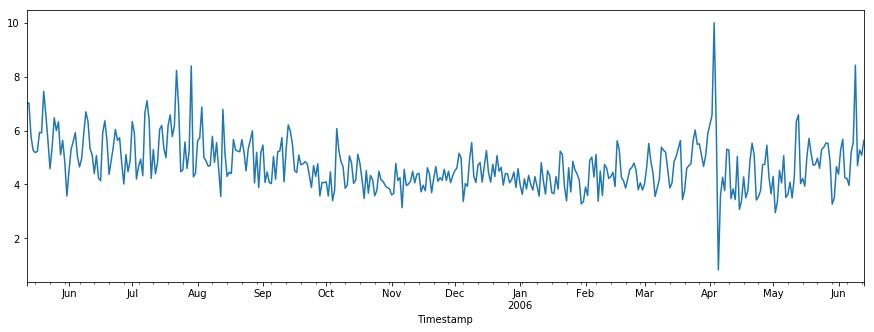

In [3]:
ts_agg.plot(figsize = (15,5))

Test for seasonality.

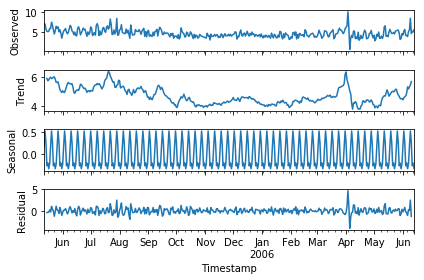

In [4]:
res = sm.tsa.seasonal_decompose(ts_agg)
resplot = res.plot()

So we see that there is seasonality is 7 days.

In [5]:
beginning = '2005.05.12'
end = '2006.06.13'

In [6]:
len(ts_dep36.iloc[10])

105

We use MACAPE loss function

In [7]:
def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

In [8]:
# IES

def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha*(t-t0+1)/(AdaptationPeriod)) + alpha*(t-t0+1)/(AdaptationPeriod)*x[t]
            y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST

In [9]:
# AES

def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if t<AdaptationPeriod:
                y = y*(1-alpha*(t-t0+1)/(AdaptationPeriod)) + alpha*(t-t0+1)/(AdaptationPeriod)*x[t]
            y = y*(1-alpha) + (alpha)*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST

In [10]:
# Winter's ES

def WintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    delta = Params['delta']
    p = Params['seasonality_period']
    
    FORECAST = [np.NAN]*(T+h)
    
    l = x[0] # initialize ts level 
    s = np.array([np.NAN]*p) # initalize seasonality values (it must be vector of lenth p)
    s[0] = 0
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
 
            if math.isnan(s[cntr % p]):
                s[cntr % p]= x[cntr+p]-x[cntr]
            
            s_saved = s[cntr % p]
            s[cntr % p] = delta*(x[cntr] - l) + (1-delta)*s[cntr % p] 
            l = alpha*(x[cntr] - s_saved) + (1-alpha)*l            
        
        FORECAST[cntr+h] = l + s[(cntr + h % p) % p]
    return FORECAST

In [11]:
# Theil-Wage's ES

def Theil_WageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NAN]*(T+h)
    
    l = x[0] 
    b = x[0]
    s = np.array([np.NAN]*p) 
    s[0] = x[0]
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
 
            if math.isnan(s[cntr % p]):
                s[cntr % p]= x[cntr+p]-x[cntr]
            
            l_saved = l
            l = alpha*(x[cntr] - s[cntr % p]) + (1-alpha)*(l+b)
            b = beta*(l - l_saved) + (1-beta)*b
            s[cntr % p] = gamma*(x[cntr] - l) + (1- gamma)*s[cntr % p] 
                        
        
        FORECAST[cntr+h] = l + b*h + s[(cntr + h % p) % p]
    return FORECAST

Now let's for all models find the best params for each TS.

In [12]:
ts = ts_dep36
ts_train = ts.loc[:'2006.03.12']
ts_test = ts.loc['2006.03.12':]

In [72]:
%%time

h = 1
rng = pd.date_range(ts_train.index[-1]+timedelta(h), ts_train.index[-1]+timedelta(h))

IES_frc_ts = pd.DataFrame(index = ts_train.index.append(rng), columns = ts_train.columns)

min_loss_IES = {}
for cntr in ts_train.columns:
    min_loss_IES[cntr] = np.inf

BEST_PARAMS_FOR_MODEL_IES = {}


alphas = np.arange(0,11, 2)/10.

epoch = 0

for cntr in ts_train.columns:
    for alpha in alphas:
        print 'epoch '+str(epoch)+' is running ...'
        IES_frc_ts[cntr] = InitExponentialSmoothing(ts_train[cntr], h, {'alpha':alpha, 'AdaptationPeriod':40})
        if abs(qualityMACAPE(ts_train[cntr], IES_frc_ts[cntr])[0]) < min_loss_IES[cntr]:

            BEST_PARAMS_FOR_MODEL_IES[cntr] = (alpha,)
            min_loss_IES[cntr] = abs(qualityMACAPE(ts_train[cntr], IES_frc_ts[cntr])[0])

                    
        epoch+=1
                
    BEST_PARAMS_FOR_MODEL_IES[cntr] = {'params': BEST_PARAMS_FOR_MODEL_IES[cntr], 'loss': min_loss_IES[cntr]}

epoch 0 is running ...
epoch 1 is running ...
epoch 2 is running ...
epoch 3 is running ...
epoch 4 is running ...
epoch 5 is running ...
epoch 6 is running ...
epoch 7 is running ...
epoch 8 is running ...
epoch 9 is running ...
epoch 10 is running ...
epoch 11 is running ...
epoch 12 is running ...
epoch 13 is running ...
epoch 14 is running ...
epoch 15 is running ...
epoch 16 is running ...
epoch 17 is running ...
epoch 18 is running ...
epoch 19 is running ...
epoch 20 is running ...
epoch 21 is running ...
epoch 22 is running ...
epoch 23 is running ...
epoch 24 is running ...
epoch 25 is running ...
epoch 26 is running ...
epoch 27 is running ...
epoch 28 is running ...
epoch 29 is running ...
epoch 30 is running ...
epoch 31 is running ...
epoch 32 is running ...
epoch 33 is running ...
epoch 34 is running ...
epoch 35 is running ...
epoch 36 is running ...
epoch 37 is running ...
epoch 38 is running ...
epoch 39 is running ...
epoch 40 is running ...
epoch 41 is running ...
ep

epoch 333 is running ...
epoch 334 is running ...
epoch 335 is running ...
epoch 336 is running ...
epoch 337 is running ...
epoch 338 is running ...
epoch 339 is running ...
epoch 340 is running ...
epoch 341 is running ...
epoch 342 is running ...
epoch 343 is running ...
epoch 344 is running ...
epoch 345 is running ...
epoch 346 is running ...
epoch 347 is running ...
epoch 348 is running ...
epoch 349 is running ...
epoch 350 is running ...
epoch 351 is running ...
epoch 352 is running ...
epoch 353 is running ...
epoch 354 is running ...
epoch 355 is running ...
epoch 356 is running ...
epoch 357 is running ...
epoch 358 is running ...
epoch 359 is running ...
epoch 360 is running ...
epoch 361 is running ...
epoch 362 is running ...
epoch 363 is running ...
epoch 364 is running ...
epoch 365 is running ...
epoch 366 is running ...
epoch 367 is running ...
epoch 368 is running ...
epoch 369 is running ...
epoch 370 is running ...
epoch 371 is running ...
epoch 372 is running ...


In [56]:
%%time

h = 1
rng = pd.date_range(ts_train.index[-1]+timedelta(h), ts_train.index[-1]+timedelta(h))

AES_frc_ts = pd.DataFrame(index = ts_train.index.append(rng), columns = ts_train.columns)

min_loss_AES = {}
for cntr in ts_train.columns:
    min_loss_AES[cntr] = np.inf

BEST_PARAMS_FOR_MODEL_AES = {}


alphas = np.arange(0,11, 2)/10.
gammas = alphas

epoch = 0

for cntr in ts_train.columns:
    for alpha in alphas:
        for gamma in gammas:
            print 'epoch '+str(epoch)+' is running ...'
            AES_frc_ts[cntr] = AdaptiveExponentialSmoothing(ts_train[cntr], h, {'alpha':alpha, 'gamma':gamma, 'AdaptationPeriod':40})
            if abs(qualityMACAPE(ts_train[cntr], AES_frc_ts[cntr])[0]) < min_loss_AES[cntr]:

                BEST_PARAMS_FOR_MODEL_AES[cntr] = (alpha, gamma)
                min_loss_AES[cntr] = abs(qualityMACAPE(ts_train[cntr], AES_frc_ts[cntr])[0])

                    
            epoch+=1
                
    BEST_PARAMS_FOR_MODEL_AES[cntr] = {'params': BEST_PARAMS_FOR_MODEL_AES[cntr], 'loss': min_loss_AES[cntr]}

epoch 0 is running ...
epoch 1 is running ...
epoch 2 is running ...
epoch 3 is running ...
epoch 4 is running ...
epoch 5 is running ...
epoch 6 is running ...
epoch 7 is running ...
epoch 8 is running ...
epoch 9 is running ...
epoch 10 is running ...
epoch 11 is running ...
epoch 12 is running ...
epoch 13 is running ...
epoch 14 is running ...
epoch 15 is running ...
epoch 16 is running ...
epoch 17 is running ...
epoch 18 is running ...
epoch 19 is running ...
epoch 20 is running ...
epoch 21 is running ...
epoch 22 is running ...
epoch 23 is running ...
epoch 24 is running ...
epoch 25 is running ...
epoch 26 is running ...
epoch 27 is running ...
epoch 28 is running ...
epoch 29 is running ...
epoch 30 is running ...
epoch 31 is running ...
epoch 32 is running ...
epoch 33 is running ...
epoch 34 is running ...
epoch 35 is running ...
epoch 36 is running ...
epoch 37 is running ...
epoch 38 is running ...
epoch 39 is running ...
epoch 40 is running ...
epoch 41 is running ...
ep

epoch 333 is running ...
epoch 334 is running ...
epoch 335 is running ...
epoch 336 is running ...
epoch 337 is running ...
epoch 338 is running ...
epoch 339 is running ...
epoch 340 is running ...
epoch 341 is running ...
epoch 342 is running ...
epoch 343 is running ...
epoch 344 is running ...
epoch 345 is running ...
epoch 346 is running ...
epoch 347 is running ...
epoch 348 is running ...
epoch 349 is running ...
epoch 350 is running ...
epoch 351 is running ...
epoch 352 is running ...
epoch 353 is running ...
epoch 354 is running ...
epoch 355 is running ...
epoch 356 is running ...
epoch 357 is running ...
epoch 358 is running ...
epoch 359 is running ...
epoch 360 is running ...
epoch 361 is running ...
epoch 362 is running ...
epoch 363 is running ...
epoch 364 is running ...
epoch 365 is running ...
epoch 366 is running ...
epoch 367 is running ...
epoch 368 is running ...
epoch 369 is running ...
epoch 370 is running ...
epoch 371 is running ...
epoch 372 is running ...


epoch 662 is running ...
epoch 663 is running ...
epoch 664 is running ...
epoch 665 is running ...
epoch 666 is running ...
epoch 667 is running ...
epoch 668 is running ...
epoch 669 is running ...
epoch 670 is running ...
epoch 671 is running ...
epoch 672 is running ...
epoch 673 is running ...
epoch 674 is running ...
epoch 675 is running ...
epoch 676 is running ...
epoch 677 is running ...
epoch 678 is running ...
epoch 679 is running ...
epoch 680 is running ...
epoch 681 is running ...
epoch 682 is running ...
epoch 683 is running ...
epoch 684 is running ...
epoch 685 is running ...
epoch 686 is running ...
epoch 687 is running ...
epoch 688 is running ...
epoch 689 is running ...
epoch 690 is running ...
epoch 691 is running ...
epoch 692 is running ...
epoch 693 is running ...
epoch 694 is running ...
epoch 695 is running ...
epoch 696 is running ...
epoch 697 is running ...
epoch 698 is running ...
epoch 699 is running ...
epoch 700 is running ...
epoch 701 is running ...


epoch 992 is running ...
epoch 993 is running ...
epoch 994 is running ...
epoch 995 is running ...
epoch 996 is running ...
epoch 997 is running ...
epoch 998 is running ...
epoch 999 is running ...
epoch 1000 is running ...
epoch 1001 is running ...
epoch 1002 is running ...
epoch 1003 is running ...
epoch 1004 is running ...
epoch 1005 is running ...
epoch 1006 is running ...
epoch 1007 is running ...
epoch 1008 is running ...
epoch 1009 is running ...
epoch 1010 is running ...
epoch 1011 is running ...
epoch 1012 is running ...
epoch 1013 is running ...
epoch 1014 is running ...
epoch 1015 is running ...
epoch 1016 is running ...
epoch 1017 is running ...
epoch 1018 is running ...
epoch 1019 is running ...
epoch 1020 is running ...
epoch 1021 is running ...
epoch 1022 is running ...
epoch 1023 is running ...
epoch 1024 is running ...
epoch 1025 is running ...
epoch 1026 is running ...
epoch 1027 is running ...
epoch 1028 is running ...
epoch 1029 is running ...
epoch 1030 is runnin

epoch 1312 is running ...
epoch 1313 is running ...
epoch 1314 is running ...
epoch 1315 is running ...
epoch 1316 is running ...
epoch 1317 is running ...
epoch 1318 is running ...
epoch 1319 is running ...
epoch 1320 is running ...
epoch 1321 is running ...
epoch 1322 is running ...
epoch 1323 is running ...
epoch 1324 is running ...
epoch 1325 is running ...
epoch 1326 is running ...
epoch 1327 is running ...
epoch 1328 is running ...
epoch 1329 is running ...
epoch 1330 is running ...
epoch 1331 is running ...
epoch 1332 is running ...
epoch 1333 is running ...
epoch 1334 is running ...
epoch 1335 is running ...
epoch 1336 is running ...
epoch 1337 is running ...
epoch 1338 is running ...
epoch 1339 is running ...
epoch 1340 is running ...
epoch 1341 is running ...
epoch 1342 is running ...
epoch 1343 is running ...
epoch 1344 is running ...
epoch 1345 is running ...
epoch 1346 is running ...
epoch 1347 is running ...
epoch 1348 is running ...
epoch 1349 is running ...
epoch 1350 i

epoch 1632 is running ...
epoch 1633 is running ...
epoch 1634 is running ...
epoch 1635 is running ...
epoch 1636 is running ...
epoch 1637 is running ...
epoch 1638 is running ...
epoch 1639 is running ...
epoch 1640 is running ...
epoch 1641 is running ...
epoch 1642 is running ...
epoch 1643 is running ...
epoch 1644 is running ...
epoch 1645 is running ...
epoch 1646 is running ...
epoch 1647 is running ...
epoch 1648 is running ...
epoch 1649 is running ...
epoch 1650 is running ...
epoch 1651 is running ...
epoch 1652 is running ...
epoch 1653 is running ...
epoch 1654 is running ...
epoch 1655 is running ...
epoch 1656 is running ...
epoch 1657 is running ...
epoch 1658 is running ...
epoch 1659 is running ...
epoch 1660 is running ...
epoch 1661 is running ...
epoch 1662 is running ...
epoch 1663 is running ...
epoch 1664 is running ...
epoch 1665 is running ...
epoch 1666 is running ...
epoch 1667 is running ...
epoch 1668 is running ...
epoch 1669 is running ...
epoch 1670 i

epoch 1951 is running ...
epoch 1952 is running ...
epoch 1953 is running ...
epoch 1954 is running ...
epoch 1955 is running ...
epoch 1956 is running ...
epoch 1957 is running ...
epoch 1958 is running ...
epoch 1959 is running ...
epoch 1960 is running ...
epoch 1961 is running ...
epoch 1962 is running ...
epoch 1963 is running ...
epoch 1964 is running ...
epoch 1965 is running ...
epoch 1966 is running ...
epoch 1967 is running ...
epoch 1968 is running ...
epoch 1969 is running ...
epoch 1970 is running ...
epoch 1971 is running ...
epoch 1972 is running ...
epoch 1973 is running ...
epoch 1974 is running ...
epoch 1975 is running ...
epoch 1976 is running ...
epoch 1977 is running ...
epoch 1978 is running ...
epoch 1979 is running ...
epoch 1980 is running ...
epoch 1981 is running ...
epoch 1982 is running ...
epoch 1983 is running ...
epoch 1984 is running ...
epoch 1985 is running ...
epoch 1986 is running ...
epoch 1987 is running ...
epoch 1988 is running ...
epoch 1989 i

epoch 2268 is running ...
epoch 2269 is running ...
epoch 2270 is running ...
epoch 2271 is running ...
epoch 2272 is running ...
epoch 2273 is running ...
epoch 2274 is running ...
epoch 2275 is running ...
epoch 2276 is running ...
epoch 2277 is running ...
epoch 2278 is running ...
epoch 2279 is running ...
epoch 2280 is running ...
epoch 2281 is running ...
epoch 2282 is running ...
epoch 2283 is running ...
epoch 2284 is running ...
epoch 2285 is running ...
epoch 2286 is running ...
epoch 2287 is running ...
epoch 2288 is running ...
epoch 2289 is running ...
epoch 2290 is running ...
epoch 2291 is running ...
epoch 2292 is running ...
epoch 2293 is running ...
epoch 2294 is running ...
epoch 2295 is running ...
epoch 2296 is running ...
epoch 2297 is running ...
epoch 2298 is running ...
epoch 2299 is running ...
epoch 2300 is running ...
epoch 2301 is running ...
epoch 2302 is running ...
epoch 2303 is running ...
epoch 2304 is running ...
epoch 2305 is running ...
epoch 2306 i

epoch 2586 is running ...
epoch 2587 is running ...
epoch 2588 is running ...
epoch 2589 is running ...
epoch 2590 is running ...
epoch 2591 is running ...
epoch 2592 is running ...
epoch 2593 is running ...
epoch 2594 is running ...
epoch 2595 is running ...
epoch 2596 is running ...
epoch 2597 is running ...
epoch 2598 is running ...
epoch 2599 is running ...
epoch 2600 is running ...
epoch 2601 is running ...
epoch 2602 is running ...
epoch 2603 is running ...
epoch 2604 is running ...
epoch 2605 is running ...
epoch 2606 is running ...
epoch 2607 is running ...
epoch 2608 is running ...
epoch 2609 is running ...
epoch 2610 is running ...
epoch 2611 is running ...
epoch 2612 is running ...
epoch 2613 is running ...
epoch 2614 is running ...
epoch 2615 is running ...
epoch 2616 is running ...
epoch 2617 is running ...
epoch 2618 is running ...
epoch 2619 is running ...
epoch 2620 is running ...
epoch 2621 is running ...
epoch 2622 is running ...
epoch 2623 is running ...
epoch 2624 i

epoch 2904 is running ...
epoch 2905 is running ...
epoch 2906 is running ...
epoch 2907 is running ...
epoch 2908 is running ...
epoch 2909 is running ...
epoch 2910 is running ...
epoch 2911 is running ...
epoch 2912 is running ...
epoch 2913 is running ...
epoch 2914 is running ...
epoch 2915 is running ...
epoch 2916 is running ...
epoch 2917 is running ...
epoch 2918 is running ...
epoch 2919 is running ...
epoch 2920 is running ...
epoch 2921 is running ...
epoch 2922 is running ...
epoch 2923 is running ...
epoch 2924 is running ...
epoch 2925 is running ...
epoch 2926 is running ...
epoch 2927 is running ...
epoch 2928 is running ...
epoch 2929 is running ...
epoch 2930 is running ...
epoch 2931 is running ...
epoch 2932 is running ...
epoch 2933 is running ...
epoch 2934 is running ...
epoch 2935 is running ...
epoch 2936 is running ...
epoch 2937 is running ...
epoch 2938 is running ...
epoch 2939 is running ...
epoch 2940 is running ...
epoch 2941 is running ...
epoch 2942 i

epoch 3220 is running ...
epoch 3221 is running ...
epoch 3222 is running ...
epoch 3223 is running ...
epoch 3224 is running ...
epoch 3225 is running ...
epoch 3226 is running ...
epoch 3227 is running ...
epoch 3228 is running ...
epoch 3229 is running ...
epoch 3230 is running ...
epoch 3231 is running ...
epoch 3232 is running ...
epoch 3233 is running ...
epoch 3234 is running ...
epoch 3235 is running ...
epoch 3236 is running ...
epoch 3237 is running ...
epoch 3238 is running ...
epoch 3239 is running ...
epoch 3240 is running ...
epoch 3241 is running ...
epoch 3242 is running ...
epoch 3243 is running ...
epoch 3244 is running ...
epoch 3245 is running ...
epoch 3246 is running ...
epoch 3247 is running ...
epoch 3248 is running ...
epoch 3249 is running ...
epoch 3250 is running ...
epoch 3251 is running ...
epoch 3252 is running ...
epoch 3253 is running ...
epoch 3254 is running ...
epoch 3255 is running ...
epoch 3256 is running ...
epoch 3257 is running ...
epoch 3258 i

epoch 3540 is running ...
epoch 3541 is running ...
epoch 3542 is running ...
epoch 3543 is running ...
epoch 3544 is running ...
epoch 3545 is running ...
epoch 3546 is running ...
epoch 3547 is running ...
epoch 3548 is running ...
epoch 3549 is running ...
epoch 3550 is running ...
epoch 3551 is running ...
epoch 3552 is running ...
epoch 3553 is running ...
epoch 3554 is running ...
epoch 3555 is running ...
epoch 3556 is running ...
epoch 3557 is running ...
epoch 3558 is running ...
epoch 3559 is running ...
epoch 3560 is running ...
epoch 3561 is running ...
epoch 3562 is running ...
epoch 3563 is running ...
epoch 3564 is running ...
epoch 3565 is running ...
epoch 3566 is running ...
epoch 3567 is running ...
epoch 3568 is running ...
epoch 3569 is running ...
epoch 3570 is running ...
epoch 3571 is running ...
epoch 3572 is running ...
epoch 3573 is running ...
epoch 3574 is running ...
epoch 3575 is running ...
epoch 3576 is running ...
epoch 3577 is running ...
epoch 3578 i

In [57]:
%%time

h = 1
rng = pd.date_range(ts_train.index[-1]+timedelta(h), ts_train.index[-1]+timedelta(h))

W_frc_ts = pd.DataFrame(index = ts_train.index.append(rng), columns = ts_train.columns)

min_loss_WES = {}
for cntr in ts_train.columns:
    min_loss_WES[cntr] = np.inf

BEST_PARAMS_FOR_MODEL_WES = {}


alphas = np.arange(0,11, 2)/10.
deltas = alphas

epoch = 0

for cntr in ts_train.columns:
    for alpha in alphas:
        for delta in deltas:
            print 'epoch '+str(epoch)+' is running ...'
            W_frc_ts[cntr] = WintersExponentialSmoothing(ts_train[cntr], h, {'alpha':alpha, 'delta': delta, 'seasonality_period': 7})
            if abs(qualityMACAPE(ts_train[cntr], W_frc_ts[cntr])[0]) < min_loss_WES[cntr]:

                BEST_PARAMS_FOR_MODEL_WES[cntr] = (alpha, delta)
                min_loss_WES[cntr] = abs(qualityMACAPE(ts_train[cntr], W_frc_ts[cntr])[0])

                    
            epoch+=1
                
    BEST_PARAMS_FOR_MODEL_WES[cntr] = {'params': BEST_PARAMS_FOR_MODEL_WES[cntr], 'loss': min_loss_WES[cntr]}

epoch 0 is running ...
epoch 1 is running ...
epoch 2 is running ...
epoch 3 is running ...
epoch 4 is running ...
epoch 5 is running ...
epoch 6 is running ...
epoch 7 is running ...
epoch 8 is running ...
epoch 9 is running ...
epoch 10 is running ...
epoch 11 is running ...
epoch 12 is running ...
epoch 13 is running ...
epoch 14 is running ...
epoch 15 is running ...
epoch 16 is running ...
epoch 17 is running ...
epoch 18 is running ...
epoch 19 is running ...
epoch 20 is running ...
epoch 21 is running ...
epoch 22 is running ...
epoch 23 is running ...
epoch 24 is running ...
epoch 25 is running ...
epoch 26 is running ...
epoch 27 is running ...
epoch 28 is running ...
epoch 29 is running ...
epoch 30 is running ...
epoch 31 is running ...
epoch 32 is running ...
epoch 33 is running ...
epoch 34 is running ...
epoch 35 is running ...
epoch 36 is running ...
epoch 37 is running ...
epoch 38 is running ...
epoch 39 is running ...
epoch 40 is running ...
epoch 41 is running ...
ep

epoch 337 is running ...
epoch 338 is running ...
epoch 339 is running ...
epoch 340 is running ...
epoch 341 is running ...
epoch 342 is running ...
epoch 343 is running ...
epoch 344 is running ...
epoch 345 is running ...
epoch 346 is running ...
epoch 347 is running ...
epoch 348 is running ...
epoch 349 is running ...
epoch 350 is running ...
epoch 351 is running ...
epoch 352 is running ...
epoch 353 is running ...
epoch 354 is running ...
epoch 355 is running ...
epoch 356 is running ...
epoch 357 is running ...
epoch 358 is running ...
epoch 359 is running ...
epoch 360 is running ...
epoch 361 is running ...
epoch 362 is running ...
epoch 363 is running ...
epoch 364 is running ...
epoch 365 is running ...
epoch 366 is running ...
epoch 367 is running ...
epoch 368 is running ...
epoch 369 is running ...
epoch 370 is running ...
epoch 371 is running ...
epoch 372 is running ...
epoch 373 is running ...
epoch 374 is running ...
epoch 375 is running ...
epoch 376 is running ...


epoch 668 is running ...
epoch 669 is running ...
epoch 670 is running ...
epoch 671 is running ...
epoch 672 is running ...
epoch 673 is running ...
epoch 674 is running ...
epoch 675 is running ...
epoch 676 is running ...
epoch 677 is running ...
epoch 678 is running ...
epoch 679 is running ...
epoch 680 is running ...
epoch 681 is running ...
epoch 682 is running ...
epoch 683 is running ...
epoch 684 is running ...
epoch 685 is running ...
epoch 686 is running ...
epoch 687 is running ...
epoch 688 is running ...
epoch 689 is running ...
epoch 690 is running ...
epoch 691 is running ...
epoch 692 is running ...
epoch 693 is running ...
epoch 694 is running ...
epoch 695 is running ...
epoch 696 is running ...
epoch 697 is running ...
epoch 698 is running ...
epoch 699 is running ...
epoch 700 is running ...
epoch 701 is running ...
epoch 702 is running ...
epoch 703 is running ...
epoch 704 is running ...
epoch 705 is running ...
epoch 706 is running ...
epoch 707 is running ...


epoch 999 is running ...
epoch 1000 is running ...
epoch 1001 is running ...
epoch 1002 is running ...
epoch 1003 is running ...
epoch 1004 is running ...
epoch 1005 is running ...
epoch 1006 is running ...
epoch 1007 is running ...
epoch 1008 is running ...
epoch 1009 is running ...
epoch 1010 is running ...
epoch 1011 is running ...
epoch 1012 is running ...
epoch 1013 is running ...
epoch 1014 is running ...
epoch 1015 is running ...
epoch 1016 is running ...
epoch 1017 is running ...
epoch 1018 is running ...
epoch 1019 is running ...
epoch 1020 is running ...
epoch 1021 is running ...
epoch 1022 is running ...
epoch 1023 is running ...
epoch 1024 is running ...
epoch 1025 is running ...
epoch 1026 is running ...
epoch 1027 is running ...
epoch 1028 is running ...
epoch 1029 is running ...
epoch 1030 is running ...
epoch 1031 is running ...
epoch 1032 is running ...
epoch 1033 is running ...
epoch 1034 is running ...
epoch 1035 is running ...
epoch 1036 is running ...
epoch 1037 is

epoch 1315 is running ...
epoch 1316 is running ...
epoch 1317 is running ...
epoch 1318 is running ...
epoch 1319 is running ...
epoch 1320 is running ...
epoch 1321 is running ...
epoch 1322 is running ...
epoch 1323 is running ...
epoch 1324 is running ...
epoch 1325 is running ...
epoch 1326 is running ...
epoch 1327 is running ...
epoch 1328 is running ...
epoch 1329 is running ...
epoch 1330 is running ...
epoch 1331 is running ...
epoch 1332 is running ...
epoch 1333 is running ...
epoch 1334 is running ...
epoch 1335 is running ...
epoch 1336 is running ...
epoch 1337 is running ...
epoch 1338 is running ...
epoch 1339 is running ...
epoch 1340 is running ...
epoch 1341 is running ...
epoch 1342 is running ...
epoch 1343 is running ...
epoch 1344 is running ...
epoch 1345 is running ...
epoch 1346 is running ...
epoch 1347 is running ...
epoch 1348 is running ...
epoch 1349 is running ...
epoch 1350 is running ...
epoch 1351 is running ...
epoch 1352 is running ...
epoch 1353 i

epoch 1635 is running ...
epoch 1636 is running ...
epoch 1637 is running ...
epoch 1638 is running ...
epoch 1639 is running ...
epoch 1640 is running ...
epoch 1641 is running ...
epoch 1642 is running ...
epoch 1643 is running ...
epoch 1644 is running ...
epoch 1645 is running ...
epoch 1646 is running ...
epoch 1647 is running ...
epoch 1648 is running ...
epoch 1649 is running ...
epoch 1650 is running ...
epoch 1651 is running ...
epoch 1652 is running ...
epoch 1653 is running ...
epoch 1654 is running ...
epoch 1655 is running ...
epoch 1656 is running ...
epoch 1657 is running ...
epoch 1658 is running ...
epoch 1659 is running ...
epoch 1660 is running ...
epoch 1661 is running ...
epoch 1662 is running ...
epoch 1663 is running ...
epoch 1664 is running ...
epoch 1665 is running ...
epoch 1666 is running ...
epoch 1667 is running ...
epoch 1668 is running ...
epoch 1669 is running ...
epoch 1670 is running ...
epoch 1671 is running ...
epoch 1672 is running ...
epoch 1673 i

epoch 1955 is running ...
epoch 1956 is running ...
epoch 1957 is running ...
epoch 1958 is running ...
epoch 1959 is running ...
epoch 1960 is running ...
epoch 1961 is running ...
epoch 1962 is running ...
epoch 1963 is running ...
epoch 1964 is running ...
epoch 1965 is running ...
epoch 1966 is running ...
epoch 1967 is running ...
epoch 1968 is running ...
epoch 1969 is running ...
epoch 1970 is running ...
epoch 1971 is running ...
epoch 1972 is running ...
epoch 1973 is running ...
epoch 1974 is running ...
epoch 1975 is running ...
epoch 1976 is running ...
epoch 1977 is running ...
epoch 1978 is running ...
epoch 1979 is running ...
epoch 1980 is running ...
epoch 1981 is running ...
epoch 1982 is running ...
epoch 1983 is running ...
epoch 1984 is running ...
epoch 1985 is running ...
epoch 1986 is running ...
epoch 1987 is running ...
epoch 1988 is running ...
epoch 1989 is running ...
epoch 1990 is running ...
epoch 1991 is running ...
epoch 1992 is running ...
epoch 1993 i

epoch 2272 is running ...
epoch 2273 is running ...
epoch 2274 is running ...
epoch 2275 is running ...
epoch 2276 is running ...
epoch 2277 is running ...
epoch 2278 is running ...
epoch 2279 is running ...
epoch 2280 is running ...
epoch 2281 is running ...
epoch 2282 is running ...
epoch 2283 is running ...
epoch 2284 is running ...
epoch 2285 is running ...
epoch 2286 is running ...
epoch 2287 is running ...
epoch 2288 is running ...
epoch 2289 is running ...
epoch 2290 is running ...
epoch 2291 is running ...
epoch 2292 is running ...
epoch 2293 is running ...
epoch 2294 is running ...
epoch 2295 is running ...
epoch 2296 is running ...
epoch 2297 is running ...
epoch 2298 is running ...
epoch 2299 is running ...
epoch 2300 is running ...
epoch 2301 is running ...
epoch 2302 is running ...
epoch 2303 is running ...
epoch 2304 is running ...
epoch 2305 is running ...
epoch 2306 is running ...
epoch 2307 is running ...
epoch 2308 is running ...
epoch 2309 is running ...
epoch 2310 i

epoch 2592 is running ...
epoch 2593 is running ...
epoch 2594 is running ...
epoch 2595 is running ...
epoch 2596 is running ...
epoch 2597 is running ...
epoch 2598 is running ...
epoch 2599 is running ...
epoch 2600 is running ...
epoch 2601 is running ...
epoch 2602 is running ...
epoch 2603 is running ...
epoch 2604 is running ...
epoch 2605 is running ...
epoch 2606 is running ...
epoch 2607 is running ...
epoch 2608 is running ...
epoch 2609 is running ...
epoch 2610 is running ...
epoch 2611 is running ...
epoch 2612 is running ...
epoch 2613 is running ...
epoch 2614 is running ...
epoch 2615 is running ...
epoch 2616 is running ...
epoch 2617 is running ...
epoch 2618 is running ...
epoch 2619 is running ...
epoch 2620 is running ...
epoch 2621 is running ...
epoch 2622 is running ...
epoch 2623 is running ...
epoch 2624 is running ...
epoch 2625 is running ...
epoch 2626 is running ...
epoch 2627 is running ...
epoch 2628 is running ...
epoch 2629 is running ...
epoch 2630 i

epoch 2913 is running ...
epoch 2914 is running ...
epoch 2915 is running ...
epoch 2916 is running ...
epoch 2917 is running ...
epoch 2918 is running ...
epoch 2919 is running ...
epoch 2920 is running ...
epoch 2921 is running ...
epoch 2922 is running ...
epoch 2923 is running ...
epoch 2924 is running ...
epoch 2925 is running ...
epoch 2926 is running ...
epoch 2927 is running ...
epoch 2928 is running ...
epoch 2929 is running ...
epoch 2930 is running ...
epoch 2931 is running ...
epoch 2932 is running ...
epoch 2933 is running ...
epoch 2934 is running ...
epoch 2935 is running ...
epoch 2936 is running ...
epoch 2937 is running ...
epoch 2938 is running ...
epoch 2939 is running ...
epoch 2940 is running ...
epoch 2941 is running ...
epoch 2942 is running ...
epoch 2943 is running ...
epoch 2944 is running ...
epoch 2945 is running ...
epoch 2946 is running ...
epoch 2947 is running ...
epoch 2948 is running ...
epoch 2949 is running ...
epoch 2950 is running ...
epoch 2951 i

epoch 3229 is running ...
epoch 3230 is running ...
epoch 3231 is running ...
epoch 3232 is running ...
epoch 3233 is running ...
epoch 3234 is running ...
epoch 3235 is running ...
epoch 3236 is running ...
epoch 3237 is running ...
epoch 3238 is running ...
epoch 3239 is running ...
epoch 3240 is running ...
epoch 3241 is running ...
epoch 3242 is running ...
epoch 3243 is running ...
epoch 3244 is running ...
epoch 3245 is running ...
epoch 3246 is running ...
epoch 3247 is running ...
epoch 3248 is running ...
epoch 3249 is running ...
epoch 3250 is running ...
epoch 3251 is running ...
epoch 3252 is running ...
epoch 3253 is running ...
epoch 3254 is running ...
epoch 3255 is running ...
epoch 3256 is running ...
epoch 3257 is running ...
epoch 3258 is running ...
epoch 3259 is running ...
epoch 3260 is running ...
epoch 3261 is running ...
epoch 3262 is running ...
epoch 3263 is running ...
epoch 3264 is running ...
epoch 3265 is running ...
epoch 3266 is running ...
epoch 3267 i

epoch 3547 is running ...
epoch 3548 is running ...
epoch 3549 is running ...
epoch 3550 is running ...
epoch 3551 is running ...
epoch 3552 is running ...
epoch 3553 is running ...
epoch 3554 is running ...
epoch 3555 is running ...
epoch 3556 is running ...
epoch 3557 is running ...
epoch 3558 is running ...
epoch 3559 is running ...
epoch 3560 is running ...
epoch 3561 is running ...
epoch 3562 is running ...
epoch 3563 is running ...
epoch 3564 is running ...
epoch 3565 is running ...
epoch 3566 is running ...
epoch 3567 is running ...
epoch 3568 is running ...
epoch 3569 is running ...
epoch 3570 is running ...
epoch 3571 is running ...
epoch 3572 is running ...
epoch 3573 is running ...
epoch 3574 is running ...
epoch 3575 is running ...
epoch 3576 is running ...
epoch 3577 is running ...
epoch 3578 is running ...
epoch 3579 is running ...
epoch 3580 is running ...
epoch 3581 is running ...
epoch 3582 is running ...
epoch 3583 is running ...
epoch 3584 is running ...
epoch 3585 i

In [58]:
%%time

h = 1
rng = pd.date_range(ts_train.index[-1]+timedelta(h), ts_train.index[-1]+timedelta(h))

T_frc_ts = pd.DataFrame(index = ts_train.index.append(rng), columns = ts_train.columns)

min_loss_TWES = {}
for cntr in ts_train.columns:
    min_loss_TWES[cntr] = np.inf

BEST_PARAMS_FOR_MODEL_TWES = {}


alphas = np.arange(0,11, 2)/10.
betas = alphas
gammas = alphas

epoch = 0

for cntr in ts_train.columns:
    for alpha in alphas:
        for beta in betas:
            for gamma in gammas:
                print 'epoch '+str(epoch)+' is running ...'
                T_frc_ts[cntr] = Theil_WageExponentialSmoothing(ts_train[cntr], h, {'alpha':alpha, 'beta': beta, 'gamma': gamma, 'seasonality_period': 7})
                if abs(qualityMACAPE(ts_train[cntr], T_frc_ts[cntr])[0]) < min_loss_TWES[cntr]:

                    BEST_PARAMS_FOR_MODEL_TWES[cntr] = (alpha, beta, gamma)
                    min_loss_TWES[cntr] = abs(qualityMACAPE(ts_train[cntr], T_frc_ts[cntr])[0])

                    
                epoch+=1
                
    BEST_PARAMS_FOR_MODEL_TWES[cntr] = {'params': BEST_PARAMS_FOR_MODEL_TWES[cntr], 'loss': min_loss_TWES[cntr]}
                            


epoch 0 is running ...
epoch 1 is running ...
epoch 2 is running ...
epoch 3 is running ...
epoch 4 is running ...
epoch 5 is running ...
epoch 6 is running ...
epoch 7 is running ...
epoch 8 is running ...
epoch 9 is running ...
epoch 10 is running ...
epoch 11 is running ...
epoch 12 is running ...
epoch 13 is running ...
epoch 14 is running ...
epoch 15 is running ...
epoch 16 is running ...
epoch 17 is running ...
epoch 18 is running ...
epoch 19 is running ...
epoch 20 is running ...
epoch 21 is running ...
epoch 22 is running ...
epoch 23 is running ...
epoch 24 is running ...
epoch 25 is running ...
epoch 26 is running ...
epoch 27 is running ...
epoch 28 is running ...
epoch 29 is running ...
epoch 30 is running ...
epoch 31 is running ...
epoch 32 is running ...
epoch 33 is running ...
epoch 34 is running ...
epoch 35 is running ...
epoch 36 is running ...
epoch 37 is running ...
epoch 38 is running ...
epoch 39 is running ...
epoch 40 is running ...
epoch 41 is running ...
ep

epoch 333 is running ...
epoch 334 is running ...
epoch 335 is running ...
epoch 336 is running ...
epoch 337 is running ...
epoch 338 is running ...
epoch 339 is running ...
epoch 340 is running ...
epoch 341 is running ...
epoch 342 is running ...
epoch 343 is running ...
epoch 344 is running ...
epoch 345 is running ...
epoch 346 is running ...
epoch 347 is running ...
epoch 348 is running ...
epoch 349 is running ...
epoch 350 is running ...
epoch 351 is running ...
epoch 352 is running ...
epoch 353 is running ...
epoch 354 is running ...
epoch 355 is running ...
epoch 356 is running ...
epoch 357 is running ...
epoch 358 is running ...
epoch 359 is running ...
epoch 360 is running ...
epoch 361 is running ...
epoch 362 is running ...
epoch 363 is running ...
epoch 364 is running ...
epoch 365 is running ...
epoch 366 is running ...
epoch 367 is running ...
epoch 368 is running ...
epoch 369 is running ...
epoch 370 is running ...
epoch 371 is running ...
epoch 372 is running ...


epoch 661 is running ...
epoch 662 is running ...
epoch 663 is running ...
epoch 664 is running ...
epoch 665 is running ...
epoch 666 is running ...
epoch 667 is running ...
epoch 668 is running ...
epoch 669 is running ...
epoch 670 is running ...
epoch 671 is running ...
epoch 672 is running ...
epoch 673 is running ...
epoch 674 is running ...
epoch 675 is running ...
epoch 676 is running ...
epoch 677 is running ...
epoch 678 is running ...
epoch 679 is running ...
epoch 680 is running ...
epoch 681 is running ...
epoch 682 is running ...
epoch 683 is running ...
epoch 684 is running ...
epoch 685 is running ...
epoch 686 is running ...
epoch 687 is running ...
epoch 688 is running ...
epoch 689 is running ...
epoch 690 is running ...
epoch 691 is running ...
epoch 692 is running ...
epoch 693 is running ...
epoch 694 is running ...
epoch 695 is running ...
epoch 696 is running ...
epoch 697 is running ...
epoch 698 is running ...
epoch 699 is running ...
epoch 700 is running ...


epoch 993 is running ...
epoch 994 is running ...
epoch 995 is running ...
epoch 996 is running ...
epoch 997 is running ...
epoch 998 is running ...
epoch 999 is running ...
epoch 1000 is running ...
epoch 1001 is running ...
epoch 1002 is running ...
epoch 1003 is running ...
epoch 1004 is running ...
epoch 1005 is running ...
epoch 1006 is running ...
epoch 1007 is running ...
epoch 1008 is running ...
epoch 1009 is running ...
epoch 1010 is running ...
epoch 1011 is running ...
epoch 1012 is running ...
epoch 1013 is running ...
epoch 1014 is running ...
epoch 1015 is running ...
epoch 1016 is running ...
epoch 1017 is running ...
epoch 1018 is running ...
epoch 1019 is running ...
epoch 1020 is running ...
epoch 1021 is running ...
epoch 1022 is running ...
epoch 1023 is running ...
epoch 1024 is running ...
epoch 1025 is running ...
epoch 1026 is running ...
epoch 1027 is running ...
epoch 1028 is running ...
epoch 1029 is running ...
epoch 1030 is running ...
epoch 1031 is runni

epoch 1312 is running ...
epoch 1313 is running ...
epoch 1314 is running ...
epoch 1315 is running ...
epoch 1316 is running ...
epoch 1317 is running ...
epoch 1318 is running ...
epoch 1319 is running ...
epoch 1320 is running ...
epoch 1321 is running ...
epoch 1322 is running ...
epoch 1323 is running ...
epoch 1324 is running ...
epoch 1325 is running ...
epoch 1326 is running ...
epoch 1327 is running ...
epoch 1328 is running ...
epoch 1329 is running ...
epoch 1330 is running ...
epoch 1331 is running ...
epoch 1332 is running ...
epoch 1333 is running ...
epoch 1334 is running ...
epoch 1335 is running ...
epoch 1336 is running ...
epoch 1337 is running ...
epoch 1338 is running ...
epoch 1339 is running ...
epoch 1340 is running ...
epoch 1341 is running ...
epoch 1342 is running ...
epoch 1343 is running ...
epoch 1344 is running ...
epoch 1345 is running ...
epoch 1346 is running ...
epoch 1347 is running ...
epoch 1348 is running ...
epoch 1349 is running ...
epoch 1350 i

epoch 1629 is running ...
epoch 1630 is running ...
epoch 1631 is running ...
epoch 1632 is running ...
epoch 1633 is running ...
epoch 1634 is running ...
epoch 1635 is running ...
epoch 1636 is running ...
epoch 1637 is running ...
epoch 1638 is running ...
epoch 1639 is running ...
epoch 1640 is running ...
epoch 1641 is running ...
epoch 1642 is running ...
epoch 1643 is running ...
epoch 1644 is running ...
epoch 1645 is running ...
epoch 1646 is running ...
epoch 1647 is running ...
epoch 1648 is running ...
epoch 1649 is running ...
epoch 1650 is running ...
epoch 1651 is running ...
epoch 1652 is running ...
epoch 1653 is running ...
epoch 1654 is running ...
epoch 1655 is running ...
epoch 1656 is running ...
epoch 1657 is running ...
epoch 1658 is running ...
epoch 1659 is running ...
epoch 1660 is running ...
epoch 1661 is running ...
epoch 1662 is running ...
epoch 1663 is running ...
epoch 1664 is running ...
epoch 1665 is running ...
epoch 1666 is running ...
epoch 1667 i

epoch 1949 is running ...
epoch 1950 is running ...
epoch 1951 is running ...
epoch 1952 is running ...
epoch 1953 is running ...
epoch 1954 is running ...
epoch 1955 is running ...
epoch 1956 is running ...
epoch 1957 is running ...
epoch 1958 is running ...
epoch 1959 is running ...
epoch 1960 is running ...
epoch 1961 is running ...
epoch 1962 is running ...
epoch 1963 is running ...
epoch 1964 is running ...
epoch 1965 is running ...
epoch 1966 is running ...
epoch 1967 is running ...
epoch 1968 is running ...
epoch 1969 is running ...
epoch 1970 is running ...
epoch 1971 is running ...
epoch 1972 is running ...
epoch 1973 is running ...
epoch 1974 is running ...
epoch 1975 is running ...
epoch 1976 is running ...
epoch 1977 is running ...
epoch 1978 is running ...
epoch 1979 is running ...
epoch 1980 is running ...
epoch 1981 is running ...
epoch 1982 is running ...
epoch 1983 is running ...
epoch 1984 is running ...
epoch 1985 is running ...
epoch 1986 is running ...
epoch 1987 i

epoch 2269 is running ...
epoch 2270 is running ...
epoch 2271 is running ...
epoch 2272 is running ...
epoch 2273 is running ...
epoch 2274 is running ...
epoch 2275 is running ...
epoch 2276 is running ...
epoch 2277 is running ...
epoch 2278 is running ...
epoch 2279 is running ...
epoch 2280 is running ...
epoch 2281 is running ...
epoch 2282 is running ...
epoch 2283 is running ...
epoch 2284 is running ...
epoch 2285 is running ...
epoch 2286 is running ...
epoch 2287 is running ...
epoch 2288 is running ...
epoch 2289 is running ...
epoch 2290 is running ...
epoch 2291 is running ...
epoch 2292 is running ...
epoch 2293 is running ...
epoch 2294 is running ...
epoch 2295 is running ...
epoch 2296 is running ...
epoch 2297 is running ...
epoch 2298 is running ...
epoch 2299 is running ...
epoch 2300 is running ...
epoch 2301 is running ...
epoch 2302 is running ...
epoch 2303 is running ...
epoch 2304 is running ...
epoch 2305 is running ...
epoch 2306 is running ...
epoch 2307 i

epoch 2587 is running ...
epoch 2588 is running ...
epoch 2589 is running ...
epoch 2590 is running ...
epoch 2591 is running ...
epoch 2592 is running ...
epoch 2593 is running ...
epoch 2594 is running ...
epoch 2595 is running ...
epoch 2596 is running ...
epoch 2597 is running ...
epoch 2598 is running ...
epoch 2599 is running ...
epoch 2600 is running ...
epoch 2601 is running ...
epoch 2602 is running ...
epoch 2603 is running ...
epoch 2604 is running ...
epoch 2605 is running ...
epoch 2606 is running ...
epoch 2607 is running ...
epoch 2608 is running ...
epoch 2609 is running ...
epoch 2610 is running ...
epoch 2611 is running ...
epoch 2612 is running ...
epoch 2613 is running ...
epoch 2614 is running ...
epoch 2615 is running ...
epoch 2616 is running ...
epoch 2617 is running ...
epoch 2618 is running ...
epoch 2619 is running ...
epoch 2620 is running ...
epoch 2621 is running ...
epoch 2622 is running ...
epoch 2623 is running ...
epoch 2624 is running ...
epoch 2625 i

epoch 2906 is running ...
epoch 2907 is running ...
epoch 2908 is running ...
epoch 2909 is running ...
epoch 2910 is running ...
epoch 2911 is running ...
epoch 2912 is running ...
epoch 2913 is running ...
epoch 2914 is running ...
epoch 2915 is running ...
epoch 2916 is running ...
epoch 2917 is running ...
epoch 2918 is running ...
epoch 2919 is running ...
epoch 2920 is running ...
epoch 2921 is running ...
epoch 2922 is running ...
epoch 2923 is running ...
epoch 2924 is running ...
epoch 2925 is running ...
epoch 2926 is running ...
epoch 2927 is running ...
epoch 2928 is running ...
epoch 2929 is running ...
epoch 2930 is running ...
epoch 2931 is running ...
epoch 2932 is running ...
epoch 2933 is running ...
epoch 2934 is running ...
epoch 2935 is running ...
epoch 2936 is running ...
epoch 2937 is running ...
epoch 2938 is running ...
epoch 2939 is running ...
epoch 2940 is running ...
epoch 2941 is running ...
epoch 2942 is running ...
epoch 2943 is running ...
epoch 2944 i

epoch 3538 is running ...
epoch 3539 is running ...
epoch 3540 is running ...
epoch 3541 is running ...
epoch 3542 is running ...
epoch 3543 is running ...
epoch 3544 is running ...
epoch 3545 is running ...
epoch 3546 is running ...
epoch 3547 is running ...
epoch 3548 is running ...
epoch 3549 is running ...
epoch 3550 is running ...
epoch 3551 is running ...
epoch 3552 is running ...
epoch 3553 is running ...
epoch 3554 is running ...
epoch 3555 is running ...
epoch 3556 is running ...
epoch 3557 is running ...
epoch 3558 is running ...
epoch 3559 is running ...
epoch 3560 is running ...
epoch 3561 is running ...
epoch 3562 is running ...
epoch 3563 is running ...
epoch 3564 is running ...
epoch 3565 is running ...
epoch 3566 is running ...
epoch 3567 is running ...
epoch 3568 is running ...
epoch 3569 is running ...
epoch 3570 is running ...
epoch 3571 is running ...
epoch 3572 is running ...
epoch 3573 is running ...
epoch 3574 is running ...
epoch 3575 is running ...
epoch 3576 i

epoch 3855 is running ...
epoch 3856 is running ...
epoch 3857 is running ...
epoch 3858 is running ...
epoch 3859 is running ...
epoch 3860 is running ...
epoch 3861 is running ...
epoch 3862 is running ...
epoch 3863 is running ...
epoch 3864 is running ...
epoch 3865 is running ...
epoch 3866 is running ...
epoch 3867 is running ...
epoch 3868 is running ...
epoch 3869 is running ...
epoch 3870 is running ...
epoch 3871 is running ...
epoch 3872 is running ...
epoch 3873 is running ...
epoch 3874 is running ...
epoch 3875 is running ...
epoch 3876 is running ...
epoch 3877 is running ...
epoch 3878 is running ...
epoch 3879 is running ...
epoch 3880 is running ...
epoch 3881 is running ...
epoch 3882 is running ...
epoch 3883 is running ...
epoch 3884 is running ...
epoch 3885 is running ...
epoch 3886 is running ...
epoch 3887 is running ...
epoch 3888 is running ...
epoch 3889 is running ...
epoch 3890 is running ...
epoch 3891 is running ...
epoch 3892 is running ...
epoch 3893 i

epoch 4171 is running ...
epoch 4172 is running ...
epoch 4173 is running ...
epoch 4174 is running ...
epoch 4175 is running ...
epoch 4176 is running ...
epoch 4177 is running ...
epoch 4178 is running ...
epoch 4179 is running ...
epoch 4180 is running ...
epoch 4181 is running ...
epoch 4182 is running ...
epoch 4183 is running ...
epoch 4184 is running ...
epoch 4185 is running ...
epoch 4186 is running ...
epoch 4187 is running ...
epoch 4188 is running ...
epoch 4189 is running ...
epoch 4190 is running ...
epoch 4191 is running ...
epoch 4192 is running ...
epoch 4193 is running ...
epoch 4194 is running ...
epoch 4195 is running ...
epoch 4196 is running ...
epoch 4197 is running ...
epoch 4198 is running ...
epoch 4199 is running ...
epoch 4200 is running ...
epoch 4201 is running ...
epoch 4202 is running ...
epoch 4203 is running ...
epoch 4204 is running ...
epoch 4205 is running ...
epoch 4206 is running ...
epoch 4207 is running ...
epoch 4208 is running ...
epoch 4209 i

epoch 4491 is running ...
epoch 4492 is running ...
epoch 4493 is running ...
epoch 4494 is running ...
epoch 4495 is running ...
epoch 4496 is running ...
epoch 4497 is running ...
epoch 4498 is running ...
epoch 4499 is running ...
epoch 4500 is running ...
epoch 4501 is running ...
epoch 4502 is running ...
epoch 4503 is running ...
epoch 4504 is running ...
epoch 4505 is running ...
epoch 4506 is running ...
epoch 4507 is running ...
epoch 4508 is running ...
epoch 4509 is running ...
epoch 4510 is running ...
epoch 4511 is running ...
epoch 4512 is running ...
epoch 4513 is running ...
epoch 4514 is running ...
epoch 4515 is running ...
epoch 4516 is running ...
epoch 4517 is running ...
epoch 4518 is running ...
epoch 4519 is running ...
epoch 4520 is running ...
epoch 4521 is running ...
epoch 4522 is running ...
epoch 4523 is running ...
epoch 4524 is running ...
epoch 4525 is running ...
epoch 4526 is running ...
epoch 4527 is running ...
epoch 4528 is running ...
epoch 4529 i

epoch 4807 is running ...
epoch 4808 is running ...
epoch 4809 is running ...
epoch 4810 is running ...
epoch 4811 is running ...
epoch 4812 is running ...
epoch 4813 is running ...
epoch 4814 is running ...
epoch 4815 is running ...
epoch 4816 is running ...
epoch 4817 is running ...
epoch 4818 is running ...
epoch 4819 is running ...
epoch 4820 is running ...
epoch 4821 is running ...
epoch 4822 is running ...
epoch 4823 is running ...
epoch 4824 is running ...
epoch 4825 is running ...
epoch 4826 is running ...
epoch 4827 is running ...
epoch 4828 is running ...
epoch 4829 is running ...
epoch 4830 is running ...
epoch 4831 is running ...
epoch 4832 is running ...
epoch 4833 is running ...
epoch 4834 is running ...
epoch 4835 is running ...
epoch 4836 is running ...
epoch 4837 is running ...
epoch 4838 is running ...
epoch 4839 is running ...
epoch 4840 is running ...
epoch 4841 is running ...
epoch 4842 is running ...
epoch 4843 is running ...
epoch 4844 is running ...
epoch 4845 i

epoch 5123 is running ...
epoch 5124 is running ...
epoch 5125 is running ...
epoch 5126 is running ...
epoch 5127 is running ...
epoch 5128 is running ...
epoch 5129 is running ...
epoch 5130 is running ...
epoch 5131 is running ...
epoch 5132 is running ...
epoch 5133 is running ...
epoch 5134 is running ...
epoch 5135 is running ...
epoch 5136 is running ...
epoch 5137 is running ...
epoch 5138 is running ...
epoch 5139 is running ...
epoch 5140 is running ...
epoch 5141 is running ...
epoch 5142 is running ...
epoch 5143 is running ...
epoch 5144 is running ...
epoch 5145 is running ...
epoch 5146 is running ...
epoch 5147 is running ...
epoch 5148 is running ...
epoch 5149 is running ...
epoch 5150 is running ...
epoch 5151 is running ...
epoch 5152 is running ...
epoch 5153 is running ...
epoch 5154 is running ...
epoch 5155 is running ...
epoch 5156 is running ...
epoch 5157 is running ...
epoch 5158 is running ...
epoch 5159 is running ...
epoch 5160 is running ...
epoch 5161 i

epoch 5440 is running ...
epoch 5441 is running ...
epoch 5442 is running ...
epoch 5443 is running ...
epoch 5444 is running ...
epoch 5445 is running ...
epoch 5446 is running ...
epoch 5447 is running ...
epoch 5448 is running ...
epoch 5449 is running ...
epoch 5450 is running ...
epoch 5451 is running ...
epoch 5452 is running ...
epoch 5453 is running ...
epoch 5454 is running ...
epoch 5455 is running ...
epoch 5456 is running ...
epoch 5457 is running ...
epoch 5458 is running ...
epoch 5459 is running ...
epoch 5460 is running ...
epoch 5461 is running ...
epoch 5462 is running ...
epoch 5463 is running ...
epoch 5464 is running ...
epoch 5465 is running ...
epoch 5466 is running ...
epoch 5467 is running ...
epoch 5468 is running ...
epoch 5469 is running ...
epoch 5470 is running ...
epoch 5471 is running ...
epoch 5472 is running ...
epoch 5473 is running ...
epoch 5474 is running ...
epoch 5475 is running ...
epoch 5476 is running ...
epoch 5477 is running ...
epoch 5478 i

epoch 5758 is running ...
epoch 5759 is running ...
epoch 5760 is running ...
epoch 5761 is running ...
epoch 5762 is running ...
epoch 5763 is running ...
epoch 5764 is running ...
epoch 5765 is running ...
epoch 5766 is running ...
epoch 5767 is running ...
epoch 5768 is running ...
epoch 5769 is running ...
epoch 5770 is running ...
epoch 5771 is running ...
epoch 5772 is running ...
epoch 5773 is running ...
epoch 5774 is running ...
epoch 5775 is running ...
epoch 5776 is running ...
epoch 5777 is running ...
epoch 5778 is running ...
epoch 5779 is running ...
epoch 5780 is running ...
epoch 5781 is running ...
epoch 5782 is running ...
epoch 5783 is running ...
epoch 5784 is running ...
epoch 5785 is running ...
epoch 5786 is running ...
epoch 5787 is running ...
epoch 5788 is running ...
epoch 5789 is running ...
epoch 5790 is running ...
epoch 5791 is running ...
epoch 5792 is running ...
epoch 5793 is running ...
epoch 5794 is running ...
epoch 5795 is running ...
epoch 5796 i

epoch 6077 is running ...
epoch 6078 is running ...
epoch 6079 is running ...
epoch 6080 is running ...
epoch 6081 is running ...
epoch 6082 is running ...
epoch 6083 is running ...
epoch 6084 is running ...
epoch 6085 is running ...
epoch 6086 is running ...
epoch 6087 is running ...
epoch 6088 is running ...
epoch 6089 is running ...
epoch 6090 is running ...
epoch 6091 is running ...
epoch 6092 is running ...
epoch 6093 is running ...
epoch 6094 is running ...
epoch 6095 is running ...
epoch 6096 is running ...
epoch 6097 is running ...
epoch 6098 is running ...
epoch 6099 is running ...
epoch 6100 is running ...
epoch 6101 is running ...
epoch 6102 is running ...
epoch 6103 is running ...
epoch 6104 is running ...
epoch 6105 is running ...
epoch 6106 is running ...
epoch 6107 is running ...
epoch 6108 is running ...
epoch 6109 is running ...
epoch 6110 is running ...
epoch 6111 is running ...
epoch 6112 is running ...
epoch 6113 is running ...
epoch 6114 is running ...
epoch 6115 i

epoch 6397 is running ...
epoch 6398 is running ...
epoch 6399 is running ...
epoch 6400 is running ...
epoch 6401 is running ...
epoch 6402 is running ...
epoch 6403 is running ...
epoch 6404 is running ...
epoch 6405 is running ...
epoch 6406 is running ...
epoch 6407 is running ...
epoch 6408 is running ...
epoch 6409 is running ...
epoch 6410 is running ...
epoch 6411 is running ...
epoch 6412 is running ...
epoch 6413 is running ...
epoch 6414 is running ...
epoch 6415 is running ...
epoch 6416 is running ...
epoch 6417 is running ...
epoch 6418 is running ...
epoch 6419 is running ...
epoch 6420 is running ...
epoch 6421 is running ...
epoch 6422 is running ...
epoch 6423 is running ...
epoch 6424 is running ...
epoch 6425 is running ...
epoch 6426 is running ...
epoch 6427 is running ...
epoch 6428 is running ...
epoch 6429 is running ...
epoch 6430 is running ...
epoch 6431 is running ...
epoch 6432 is running ...
epoch 6433 is running ...
epoch 6434 is running ...
epoch 6435 i

epoch 6717 is running ...
epoch 6718 is running ...
epoch 6719 is running ...
epoch 6720 is running ...
epoch 6721 is running ...
epoch 6722 is running ...
epoch 6723 is running ...
epoch 6724 is running ...
epoch 6725 is running ...
epoch 6726 is running ...
epoch 6727 is running ...
epoch 6728 is running ...
epoch 6729 is running ...
epoch 6730 is running ...
epoch 6731 is running ...
epoch 6732 is running ...
epoch 6733 is running ...
epoch 6734 is running ...
epoch 6735 is running ...
epoch 6736 is running ...
epoch 6737 is running ...
epoch 6738 is running ...
epoch 6739 is running ...
epoch 6740 is running ...
epoch 6741 is running ...
epoch 6742 is running ...
epoch 6743 is running ...
epoch 6744 is running ...
epoch 6745 is running ...
epoch 6746 is running ...
epoch 6747 is running ...
epoch 6748 is running ...
epoch 6749 is running ...
epoch 6750 is running ...
epoch 6751 is running ...
epoch 6752 is running ...
epoch 6753 is running ...
epoch 6754 is running ...
epoch 6755 i

epoch 7036 is running ...
epoch 7037 is running ...
epoch 7038 is running ...
epoch 7039 is running ...
epoch 7040 is running ...
epoch 7041 is running ...
epoch 7042 is running ...
epoch 7043 is running ...
epoch 7044 is running ...
epoch 7045 is running ...
epoch 7046 is running ...
epoch 7047 is running ...
epoch 7048 is running ...
epoch 7049 is running ...
epoch 7050 is running ...
epoch 7051 is running ...
epoch 7052 is running ...
epoch 7053 is running ...
epoch 7054 is running ...
epoch 7055 is running ...
epoch 7056 is running ...
epoch 7057 is running ...
epoch 7058 is running ...
epoch 7059 is running ...
epoch 7060 is running ...
epoch 7061 is running ...
epoch 7062 is running ...
epoch 7063 is running ...
epoch 7064 is running ...
epoch 7065 is running ...
epoch 7066 is running ...
epoch 7067 is running ...
epoch 7068 is running ...
epoch 7069 is running ...
epoch 7070 is running ...
epoch 7071 is running ...
epoch 7072 is running ...
epoch 7073 is running ...
epoch 7074 i

epoch 7357 is running ...
epoch 7358 is running ...
epoch 7359 is running ...
epoch 7360 is running ...
epoch 7361 is running ...
epoch 7362 is running ...
epoch 7363 is running ...
epoch 7364 is running ...
epoch 7365 is running ...
epoch 7366 is running ...
epoch 7367 is running ...
epoch 7368 is running ...
epoch 7369 is running ...
epoch 7370 is running ...
epoch 7371 is running ...
epoch 7372 is running ...
epoch 7373 is running ...
epoch 7374 is running ...
epoch 7375 is running ...
epoch 7376 is running ...
epoch 7377 is running ...
epoch 7378 is running ...
epoch 7379 is running ...
epoch 7380 is running ...
epoch 7381 is running ...
epoch 7382 is running ...
epoch 7383 is running ...
epoch 7384 is running ...
epoch 7385 is running ...
epoch 7386 is running ...
epoch 7387 is running ...
epoch 7388 is running ...
epoch 7389 is running ...
epoch 7390 is running ...
epoch 7391 is running ...
epoch 7392 is running ...
epoch 7393 is running ...
epoch 7394 is running ...
epoch 7395 i

epoch 7677 is running ...
epoch 7678 is running ...
epoch 7679 is running ...
epoch 7680 is running ...
epoch 7681 is running ...
epoch 7682 is running ...
epoch 7683 is running ...
epoch 7684 is running ...
epoch 7685 is running ...
epoch 7686 is running ...
epoch 7687 is running ...
epoch 7688 is running ...
epoch 7689 is running ...
epoch 7690 is running ...
epoch 7691 is running ...
epoch 7692 is running ...
epoch 7693 is running ...
epoch 7694 is running ...
epoch 7695 is running ...
epoch 7696 is running ...
epoch 7697 is running ...
epoch 7698 is running ...
epoch 7699 is running ...
epoch 7700 is running ...
epoch 7701 is running ...
epoch 7702 is running ...
epoch 7703 is running ...
epoch 7704 is running ...
epoch 7705 is running ...
epoch 7706 is running ...
epoch 7707 is running ...
epoch 7708 is running ...
epoch 7709 is running ...
epoch 7710 is running ...
epoch 7711 is running ...
epoch 7712 is running ...
epoch 7713 is running ...
epoch 7714 is running ...
epoch 7715 i

epoch 7996 is running ...
epoch 7997 is running ...
epoch 7998 is running ...
epoch 7999 is running ...
epoch 8000 is running ...
epoch 8001 is running ...
epoch 8002 is running ...
epoch 8003 is running ...
epoch 8004 is running ...
epoch 8005 is running ...
epoch 8006 is running ...
epoch 8007 is running ...
epoch 8008 is running ...
epoch 8009 is running ...
epoch 8010 is running ...
epoch 8011 is running ...
epoch 8012 is running ...
epoch 8013 is running ...
epoch 8014 is running ...
epoch 8015 is running ...
epoch 8016 is running ...
epoch 8017 is running ...
epoch 8018 is running ...
epoch 8019 is running ...
epoch 8020 is running ...
epoch 8021 is running ...
epoch 8022 is running ...
epoch 8023 is running ...
epoch 8024 is running ...
epoch 8025 is running ...
epoch 8026 is running ...
epoch 8027 is running ...
epoch 8028 is running ...
epoch 8029 is running ...
epoch 8030 is running ...
epoch 8031 is running ...
epoch 8032 is running ...
epoch 8033 is running ...
epoch 8034 i

epoch 8316 is running ...
epoch 8317 is running ...
epoch 8318 is running ...
epoch 8319 is running ...
epoch 8320 is running ...
epoch 8321 is running ...
epoch 8322 is running ...
epoch 8323 is running ...
epoch 8324 is running ...
epoch 8325 is running ...
epoch 8326 is running ...
epoch 8327 is running ...
epoch 8328 is running ...
epoch 8329 is running ...
epoch 8330 is running ...
epoch 8331 is running ...
epoch 8332 is running ...
epoch 8333 is running ...
epoch 8334 is running ...
epoch 8335 is running ...
epoch 8336 is running ...
epoch 8337 is running ...
epoch 8338 is running ...
epoch 8339 is running ...
epoch 8340 is running ...
epoch 8341 is running ...
epoch 8342 is running ...
epoch 8343 is running ...
epoch 8344 is running ...
epoch 8345 is running ...
epoch 8346 is running ...
epoch 8347 is running ...
epoch 8348 is running ...
epoch 8349 is running ...
epoch 8350 is running ...
epoch 8351 is running ...
epoch 8352 is running ...
epoch 8353 is running ...
epoch 8354 i

epoch 8637 is running ...
epoch 8638 is running ...
epoch 8639 is running ...
epoch 8640 is running ...
epoch 8641 is running ...
epoch 8642 is running ...
epoch 8643 is running ...
epoch 8644 is running ...
epoch 8645 is running ...
epoch 8646 is running ...
epoch 8647 is running ...
epoch 8648 is running ...
epoch 8649 is running ...
epoch 8650 is running ...
epoch 8651 is running ...
epoch 8652 is running ...
epoch 8653 is running ...
epoch 8654 is running ...
epoch 8655 is running ...
epoch 8656 is running ...
epoch 8657 is running ...
epoch 8658 is running ...
epoch 8659 is running ...
epoch 8660 is running ...
epoch 8661 is running ...
epoch 8662 is running ...
epoch 8663 is running ...
epoch 8664 is running ...
epoch 8665 is running ...
epoch 8666 is running ...
epoch 8667 is running ...
epoch 8668 is running ...
epoch 8669 is running ...
epoch 8670 is running ...
epoch 8671 is running ...
epoch 8672 is running ...
epoch 8673 is running ...
epoch 8674 is running ...
epoch 8675 i

epoch 8957 is running ...
epoch 8958 is running ...
epoch 8959 is running ...
epoch 8960 is running ...
epoch 8961 is running ...
epoch 8962 is running ...
epoch 8963 is running ...
epoch 8964 is running ...
epoch 8965 is running ...
epoch 8966 is running ...
epoch 8967 is running ...
epoch 8968 is running ...
epoch 8969 is running ...
epoch 8970 is running ...
epoch 8971 is running ...
epoch 8972 is running ...
epoch 8973 is running ...
epoch 8974 is running ...
epoch 8975 is running ...
epoch 8976 is running ...
epoch 8977 is running ...
epoch 8978 is running ...
epoch 8979 is running ...
epoch 8980 is running ...
epoch 8981 is running ...
epoch 8982 is running ...
epoch 8983 is running ...
epoch 8984 is running ...
epoch 8985 is running ...
epoch 8986 is running ...
epoch 8987 is running ...
epoch 8988 is running ...
epoch 8989 is running ...
epoch 8990 is running ...
epoch 8991 is running ...
epoch 8992 is running ...
epoch 8993 is running ...
epoch 8994 is running ...
epoch 8995 i

epoch 9276 is running ...
epoch 9277 is running ...
epoch 9278 is running ...
epoch 9279 is running ...
epoch 9280 is running ...
epoch 9281 is running ...
epoch 9282 is running ...
epoch 9283 is running ...
epoch 9284 is running ...
epoch 9285 is running ...
epoch 9286 is running ...
epoch 9287 is running ...
epoch 9288 is running ...
epoch 9289 is running ...
epoch 9290 is running ...
epoch 9291 is running ...
epoch 9292 is running ...
epoch 9293 is running ...
epoch 9294 is running ...
epoch 9295 is running ...
epoch 9296 is running ...
epoch 9297 is running ...
epoch 9298 is running ...
epoch 9299 is running ...
epoch 9300 is running ...
epoch 9301 is running ...
epoch 9302 is running ...
epoch 9303 is running ...
epoch 9304 is running ...
epoch 9305 is running ...
epoch 9306 is running ...
epoch 9307 is running ...
epoch 9308 is running ...
epoch 9309 is running ...
epoch 9310 is running ...
epoch 9311 is running ...
epoch 9312 is running ...
epoch 9313 is running ...
epoch 9314 i

epoch 9908 is running ...
epoch 9909 is running ...
epoch 9910 is running ...
epoch 9911 is running ...
epoch 9912 is running ...
epoch 9913 is running ...
epoch 9914 is running ...
epoch 9915 is running ...
epoch 9916 is running ...
epoch 9917 is running ...
epoch 9918 is running ...
epoch 9919 is running ...
epoch 9920 is running ...
epoch 9921 is running ...
epoch 9922 is running ...
epoch 9923 is running ...
epoch 9924 is running ...
epoch 9925 is running ...
epoch 9926 is running ...
epoch 9927 is running ...
epoch 9928 is running ...
epoch 9929 is running ...
epoch 9930 is running ...
epoch 9931 is running ...
epoch 9932 is running ...
epoch 9933 is running ...
epoch 9934 is running ...
epoch 9935 is running ...
epoch 9936 is running ...
epoch 9937 is running ...
epoch 9938 is running ...
epoch 9939 is running ...
epoch 9940 is running ...
epoch 9941 is running ...
epoch 9942 is running ...
epoch 9943 is running ...
epoch 9944 is running ...
epoch 9945 is running ...
epoch 9946 i

epoch 10220 is running ...
epoch 10221 is running ...
epoch 10222 is running ...
epoch 10223 is running ...
epoch 10224 is running ...
epoch 10225 is running ...
epoch 10226 is running ...
epoch 10227 is running ...
epoch 10228 is running ...
epoch 10229 is running ...
epoch 10230 is running ...
epoch 10231 is running ...
epoch 10232 is running ...
epoch 10233 is running ...
epoch 10234 is running ...
epoch 10235 is running ...
epoch 10236 is running ...
epoch 10237 is running ...
epoch 10238 is running ...
epoch 10239 is running ...
epoch 10240 is running ...
epoch 10241 is running ...
epoch 10242 is running ...
epoch 10243 is running ...
epoch 10244 is running ...
epoch 10245 is running ...
epoch 10246 is running ...
epoch 10247 is running ...
epoch 10248 is running ...
epoch 10249 is running ...
epoch 10250 is running ...
epoch 10251 is running ...
epoch 10252 is running ...
epoch 10253 is running ...
epoch 10254 is running ...
epoch 10255 is running ...
epoch 10256 is running ...
e

epoch 10524 is running ...
epoch 10525 is running ...
epoch 10526 is running ...
epoch 10527 is running ...
epoch 10528 is running ...
epoch 10529 is running ...
epoch 10530 is running ...
epoch 10531 is running ...
epoch 10532 is running ...
epoch 10533 is running ...
epoch 10534 is running ...
epoch 10535 is running ...
epoch 10536 is running ...
epoch 10537 is running ...
epoch 10538 is running ...
epoch 10539 is running ...
epoch 10540 is running ...
epoch 10541 is running ...
epoch 10542 is running ...
epoch 10543 is running ...
epoch 10544 is running ...
epoch 10545 is running ...
epoch 10546 is running ...
epoch 10547 is running ...
epoch 10548 is running ...
epoch 10549 is running ...
epoch 10550 is running ...
epoch 10551 is running ...
epoch 10552 is running ...
epoch 10553 is running ...
epoch 10554 is running ...
epoch 10555 is running ...
epoch 10556 is running ...
epoch 10557 is running ...
epoch 10558 is running ...
epoch 10559 is running ...
epoch 10560 is running ...
e

epoch 10830 is running ...
epoch 10831 is running ...
epoch 10832 is running ...
epoch 10833 is running ...
epoch 10834 is running ...
epoch 10835 is running ...
epoch 10836 is running ...
epoch 10837 is running ...
epoch 10838 is running ...
epoch 10839 is running ...
epoch 10840 is running ...
epoch 10841 is running ...
epoch 10842 is running ...
epoch 10843 is running ...
epoch 10844 is running ...
epoch 10845 is running ...
epoch 10846 is running ...
epoch 10847 is running ...
epoch 10848 is running ...
epoch 10849 is running ...
epoch 10850 is running ...
epoch 10851 is running ...
epoch 10852 is running ...
epoch 10853 is running ...
epoch 10854 is running ...
epoch 10855 is running ...
epoch 10856 is running ...
epoch 10857 is running ...
epoch 10858 is running ...
epoch 10859 is running ...
epoch 10860 is running ...
epoch 10861 is running ...
epoch 10862 is running ...
epoch 10863 is running ...
epoch 10864 is running ...
epoch 10865 is running ...
epoch 10866 is running ...
e

epoch 11137 is running ...
epoch 11138 is running ...
epoch 11139 is running ...
epoch 11140 is running ...
epoch 11141 is running ...
epoch 11142 is running ...
epoch 11143 is running ...
epoch 11144 is running ...
epoch 11145 is running ...
epoch 11146 is running ...
epoch 11147 is running ...
epoch 11148 is running ...
epoch 11149 is running ...
epoch 11150 is running ...
epoch 11151 is running ...
epoch 11152 is running ...
epoch 11153 is running ...
epoch 11154 is running ...
epoch 11155 is running ...
epoch 11156 is running ...
epoch 11157 is running ...
epoch 11158 is running ...
epoch 11159 is running ...
epoch 11160 is running ...
epoch 11161 is running ...
epoch 11162 is running ...
epoch 11163 is running ...
epoch 11164 is running ...
epoch 11165 is running ...
epoch 11166 is running ...
epoch 11167 is running ...
epoch 11168 is running ...
epoch 11169 is running ...
epoch 11170 is running ...
epoch 11171 is running ...
epoch 11172 is running ...
epoch 11173 is running ...
e

epoch 11443 is running ...
epoch 11444 is running ...
epoch 11445 is running ...
epoch 11446 is running ...
epoch 11447 is running ...
epoch 11448 is running ...
epoch 11449 is running ...
epoch 11450 is running ...
epoch 11451 is running ...
epoch 11452 is running ...
epoch 11453 is running ...
epoch 11454 is running ...
epoch 11455 is running ...
epoch 11456 is running ...
epoch 11457 is running ...
epoch 11458 is running ...
epoch 11459 is running ...
epoch 11460 is running ...
epoch 11461 is running ...
epoch 11462 is running ...
epoch 11463 is running ...
epoch 11464 is running ...
epoch 11465 is running ...
epoch 11466 is running ...
epoch 11467 is running ...
epoch 11468 is running ...
epoch 11469 is running ...
epoch 11470 is running ...
epoch 11471 is running ...
epoch 11472 is running ...
epoch 11473 is running ...
epoch 11474 is running ...
epoch 11475 is running ...
epoch 11476 is running ...
epoch 11477 is running ...
epoch 11478 is running ...
epoch 11479 is running ...
e

epoch 11753 is running ...
epoch 11754 is running ...
epoch 11755 is running ...
epoch 11756 is running ...
epoch 11757 is running ...
epoch 11758 is running ...
epoch 11759 is running ...
epoch 11760 is running ...
epoch 11761 is running ...
epoch 11762 is running ...
epoch 11763 is running ...
epoch 11764 is running ...
epoch 11765 is running ...
epoch 11766 is running ...
epoch 11767 is running ...
epoch 11768 is running ...
epoch 11769 is running ...
epoch 11770 is running ...
epoch 11771 is running ...
epoch 11772 is running ...
epoch 11773 is running ...
epoch 11774 is running ...
epoch 11775 is running ...
epoch 11776 is running ...
epoch 11777 is running ...
epoch 11778 is running ...
epoch 11779 is running ...
epoch 11780 is running ...
epoch 11781 is running ...
epoch 11782 is running ...
epoch 11783 is running ...
epoch 11784 is running ...
epoch 11785 is running ...
epoch 11786 is running ...
epoch 11787 is running ...
epoch 11788 is running ...
epoch 11789 is running ...
e

epoch 12059 is running ...
epoch 12060 is running ...
epoch 12061 is running ...
epoch 12062 is running ...
epoch 12063 is running ...
epoch 12064 is running ...
epoch 12065 is running ...
epoch 12066 is running ...
epoch 12067 is running ...
epoch 12068 is running ...
epoch 12069 is running ...
epoch 12070 is running ...
epoch 12071 is running ...
epoch 12072 is running ...
epoch 12073 is running ...
epoch 12074 is running ...
epoch 12075 is running ...
epoch 12076 is running ...
epoch 12077 is running ...
epoch 12078 is running ...
epoch 12079 is running ...
epoch 12080 is running ...
epoch 12081 is running ...
epoch 12082 is running ...
epoch 12083 is running ...
epoch 12084 is running ...
epoch 12085 is running ...
epoch 12086 is running ...
epoch 12087 is running ...
epoch 12088 is running ...
epoch 12089 is running ...
epoch 12090 is running ...
epoch 12091 is running ...
epoch 12092 is running ...
epoch 12093 is running ...
epoch 12094 is running ...
epoch 12095 is running ...
e

epoch 12369 is running ...
epoch 12370 is running ...
epoch 12371 is running ...
epoch 12372 is running ...
epoch 12373 is running ...
epoch 12374 is running ...
epoch 12375 is running ...
epoch 12376 is running ...
epoch 12377 is running ...
epoch 12378 is running ...
epoch 12379 is running ...
epoch 12380 is running ...
epoch 12381 is running ...
epoch 12382 is running ...
epoch 12383 is running ...
epoch 12384 is running ...
epoch 12385 is running ...
epoch 12386 is running ...
epoch 12387 is running ...
epoch 12388 is running ...
epoch 12389 is running ...
epoch 12390 is running ...
epoch 12391 is running ...
epoch 12392 is running ...
epoch 12393 is running ...
epoch 12394 is running ...
epoch 12395 is running ...
epoch 12396 is running ...
epoch 12397 is running ...
epoch 12398 is running ...
epoch 12399 is running ...
epoch 12400 is running ...
epoch 12401 is running ...
epoch 12402 is running ...
epoch 12403 is running ...
epoch 12404 is running ...
epoch 12405 is running ...
e

epoch 12674 is running ...
epoch 12675 is running ...
epoch 12676 is running ...
epoch 12677 is running ...
epoch 12678 is running ...
epoch 12679 is running ...
epoch 12680 is running ...
epoch 12681 is running ...
epoch 12682 is running ...
epoch 12683 is running ...
epoch 12684 is running ...
epoch 12685 is running ...
epoch 12686 is running ...
epoch 12687 is running ...
epoch 12688 is running ...
epoch 12689 is running ...
epoch 12690 is running ...
epoch 12691 is running ...
epoch 12692 is running ...
epoch 12693 is running ...
epoch 12694 is running ...
epoch 12695 is running ...
epoch 12696 is running ...
epoch 12697 is running ...
epoch 12698 is running ...
epoch 12699 is running ...
epoch 12700 is running ...
epoch 12701 is running ...
epoch 12702 is running ...
epoch 12703 is running ...
epoch 12704 is running ...
epoch 12705 is running ...
epoch 12706 is running ...
epoch 12707 is running ...
epoch 12708 is running ...
epoch 12709 is running ...
epoch 12710 is running ...
e

epoch 12980 is running ...
epoch 12981 is running ...
epoch 12982 is running ...
epoch 12983 is running ...
epoch 12984 is running ...
epoch 12985 is running ...
epoch 12986 is running ...
epoch 12987 is running ...
epoch 12988 is running ...
epoch 12989 is running ...
epoch 12990 is running ...
epoch 12991 is running ...
epoch 12992 is running ...
epoch 12993 is running ...
epoch 12994 is running ...
epoch 12995 is running ...
epoch 12996 is running ...
epoch 12997 is running ...
epoch 12998 is running ...
epoch 12999 is running ...
epoch 13000 is running ...
epoch 13001 is running ...
epoch 13002 is running ...
epoch 13003 is running ...
epoch 13004 is running ...
epoch 13005 is running ...
epoch 13006 is running ...
epoch 13007 is running ...
epoch 13008 is running ...
epoch 13009 is running ...
epoch 13010 is running ...
epoch 13011 is running ...
epoch 13012 is running ...
epoch 13013 is running ...
epoch 13014 is running ...
epoch 13015 is running ...
epoch 13016 is running ...
e

epoch 13286 is running ...
epoch 13287 is running ...
epoch 13288 is running ...
epoch 13289 is running ...
epoch 13290 is running ...
epoch 13291 is running ...
epoch 13292 is running ...
epoch 13293 is running ...
epoch 13294 is running ...
epoch 13295 is running ...
epoch 13296 is running ...
epoch 13297 is running ...
epoch 13298 is running ...
epoch 13299 is running ...
epoch 13300 is running ...
epoch 13301 is running ...
epoch 13302 is running ...
epoch 13303 is running ...
epoch 13304 is running ...
epoch 13305 is running ...
epoch 13306 is running ...
epoch 13307 is running ...
epoch 13308 is running ...
epoch 13309 is running ...
epoch 13310 is running ...
epoch 13311 is running ...
epoch 13312 is running ...
epoch 13313 is running ...
epoch 13314 is running ...
epoch 13315 is running ...
epoch 13316 is running ...
epoch 13317 is running ...
epoch 13318 is running ...
epoch 13319 is running ...
epoch 13320 is running ...
epoch 13321 is running ...
epoch 13322 is running ...
e

epoch 13897 is running ...
epoch 13898 is running ...
epoch 13899 is running ...
epoch 13900 is running ...
epoch 13901 is running ...
epoch 13902 is running ...
epoch 13903 is running ...
epoch 13904 is running ...
epoch 13905 is running ...
epoch 13906 is running ...
epoch 13907 is running ...
epoch 13908 is running ...
epoch 13909 is running ...
epoch 13910 is running ...
epoch 13911 is running ...
epoch 13912 is running ...
epoch 13913 is running ...
epoch 13914 is running ...
epoch 13915 is running ...
epoch 13916 is running ...
epoch 13917 is running ...
epoch 13918 is running ...
epoch 13919 is running ...
epoch 13920 is running ...
epoch 13921 is running ...
epoch 13922 is running ...
epoch 13923 is running ...
epoch 13924 is running ...
epoch 13925 is running ...
epoch 13926 is running ...
epoch 13927 is running ...
epoch 13928 is running ...
epoch 13929 is running ...
epoch 13930 is running ...
epoch 13931 is running ...
epoch 13932 is running ...
epoch 13933 is running ...
e

epoch 14201 is running ...
epoch 14202 is running ...
epoch 14203 is running ...
epoch 14204 is running ...
epoch 14205 is running ...
epoch 14206 is running ...
epoch 14207 is running ...
epoch 14208 is running ...
epoch 14209 is running ...
epoch 14210 is running ...
epoch 14211 is running ...
epoch 14212 is running ...
epoch 14213 is running ...
epoch 14214 is running ...
epoch 14215 is running ...
epoch 14216 is running ...
epoch 14217 is running ...
epoch 14218 is running ...
epoch 14219 is running ...
epoch 14220 is running ...
epoch 14221 is running ...
epoch 14222 is running ...
epoch 14223 is running ...
epoch 14224 is running ...
epoch 14225 is running ...
epoch 14226 is running ...
epoch 14227 is running ...
epoch 14228 is running ...
epoch 14229 is running ...
epoch 14230 is running ...
epoch 14231 is running ...
epoch 14232 is running ...
epoch 14233 is running ...
epoch 14234 is running ...
epoch 14235 is running ...
epoch 14236 is running ...
epoch 14237 is running ...
e

epoch 14509 is running ...
epoch 14510 is running ...
epoch 14511 is running ...
epoch 14512 is running ...
epoch 14513 is running ...
epoch 14514 is running ...
epoch 14515 is running ...
epoch 14516 is running ...
epoch 14517 is running ...
epoch 14518 is running ...
epoch 14519 is running ...
epoch 14520 is running ...
epoch 14521 is running ...
epoch 14522 is running ...
epoch 14523 is running ...
epoch 14524 is running ...
epoch 14525 is running ...
epoch 14526 is running ...
epoch 14527 is running ...
epoch 14528 is running ...
epoch 14529 is running ...
epoch 14530 is running ...
epoch 14531 is running ...
epoch 14532 is running ...
epoch 14533 is running ...
epoch 14534 is running ...
epoch 14535 is running ...
epoch 14536 is running ...
epoch 14537 is running ...
epoch 14538 is running ...
epoch 14539 is running ...
epoch 14540 is running ...
epoch 14541 is running ...
epoch 14542 is running ...
epoch 14543 is running ...
epoch 14544 is running ...
epoch 14545 is running ...
e

epoch 15121 is running ...
epoch 15122 is running ...
epoch 15123 is running ...
epoch 15124 is running ...
epoch 15125 is running ...
epoch 15126 is running ...
epoch 15127 is running ...
epoch 15128 is running ...
epoch 15129 is running ...
epoch 15130 is running ...
epoch 15131 is running ...
epoch 15132 is running ...
epoch 15133 is running ...
epoch 15134 is running ...
epoch 15135 is running ...
epoch 15136 is running ...
epoch 15137 is running ...
epoch 15138 is running ...
epoch 15139 is running ...
epoch 15140 is running ...
epoch 15141 is running ...
epoch 15142 is running ...
epoch 15143 is running ...
epoch 15144 is running ...
epoch 15145 is running ...
epoch 15146 is running ...
epoch 15147 is running ...
epoch 15148 is running ...
epoch 15149 is running ...
epoch 15150 is running ...
epoch 15151 is running ...
epoch 15152 is running ...
epoch 15153 is running ...
epoch 15154 is running ...
epoch 15155 is running ...
epoch 15156 is running ...
epoch 15157 is running ...
e

epoch 15728 is running ...
epoch 15729 is running ...
epoch 15730 is running ...
epoch 15731 is running ...
epoch 15732 is running ...
epoch 15733 is running ...
epoch 15734 is running ...
epoch 15735 is running ...
epoch 15736 is running ...
epoch 15737 is running ...
epoch 15738 is running ...
epoch 15739 is running ...
epoch 15740 is running ...
epoch 15741 is running ...
epoch 15742 is running ...
epoch 15743 is running ...
epoch 15744 is running ...
epoch 15745 is running ...
epoch 15746 is running ...
epoch 15747 is running ...
epoch 15748 is running ...
epoch 15749 is running ...
epoch 15750 is running ...
epoch 15751 is running ...
epoch 15752 is running ...
epoch 15753 is running ...
epoch 15754 is running ...
epoch 15755 is running ...
epoch 15756 is running ...
epoch 15757 is running ...
epoch 15758 is running ...
epoch 15759 is running ...
epoch 15760 is running ...
epoch 15761 is running ...
epoch 15762 is running ...
epoch 15763 is running ...
epoch 15764 is running ...
e

epoch 16034 is running ...
epoch 16035 is running ...
epoch 16036 is running ...
epoch 16037 is running ...
epoch 16038 is running ...
epoch 16039 is running ...
epoch 16040 is running ...
epoch 16041 is running ...
epoch 16042 is running ...
epoch 16043 is running ...
epoch 16044 is running ...
epoch 16045 is running ...
epoch 16046 is running ...
epoch 16047 is running ...
epoch 16048 is running ...
epoch 16049 is running ...
epoch 16050 is running ...
epoch 16051 is running ...
epoch 16052 is running ...
epoch 16053 is running ...
epoch 16054 is running ...
epoch 16055 is running ...
epoch 16056 is running ...
epoch 16057 is running ...
epoch 16058 is running ...
epoch 16059 is running ...
epoch 16060 is running ...
epoch 16061 is running ...
epoch 16062 is running ...
epoch 16063 is running ...
epoch 16064 is running ...
epoch 16065 is running ...
epoch 16066 is running ...
epoch 16067 is running ...
epoch 16068 is running ...
epoch 16069 is running ...
epoch 16070 is running ...
e

epoch 16340 is running ...
epoch 16341 is running ...
epoch 16342 is running ...
epoch 16343 is running ...
epoch 16344 is running ...
epoch 16345 is running ...
epoch 16346 is running ...
epoch 16347 is running ...
epoch 16348 is running ...
epoch 16349 is running ...
epoch 16350 is running ...
epoch 16351 is running ...
epoch 16352 is running ...
epoch 16353 is running ...
epoch 16354 is running ...
epoch 16355 is running ...
epoch 16356 is running ...
epoch 16357 is running ...
epoch 16358 is running ...
epoch 16359 is running ...
epoch 16360 is running ...
epoch 16361 is running ...
epoch 16362 is running ...
epoch 16363 is running ...
epoch 16364 is running ...
epoch 16365 is running ...
epoch 16366 is running ...
epoch 16367 is running ...
epoch 16368 is running ...
epoch 16369 is running ...
epoch 16370 is running ...
epoch 16371 is running ...
epoch 16372 is running ...
epoch 16373 is running ...
epoch 16374 is running ...
epoch 16375 is running ...
epoch 16376 is running ...
e

epoch 16647 is running ...
epoch 16648 is running ...
epoch 16649 is running ...
epoch 16650 is running ...
epoch 16651 is running ...
epoch 16652 is running ...
epoch 16653 is running ...
epoch 16654 is running ...
epoch 16655 is running ...
epoch 16656 is running ...
epoch 16657 is running ...
epoch 16658 is running ...
epoch 16659 is running ...
epoch 16660 is running ...
epoch 16661 is running ...
epoch 16662 is running ...
epoch 16663 is running ...
epoch 16664 is running ...
epoch 16665 is running ...
epoch 16666 is running ...
epoch 16667 is running ...
epoch 16668 is running ...
epoch 16669 is running ...
epoch 16670 is running ...
epoch 16671 is running ...
epoch 16672 is running ...
epoch 16673 is running ...
epoch 16674 is running ...
epoch 16675 is running ...
epoch 16676 is running ...
epoch 16677 is running ...
epoch 16678 is running ...
epoch 16679 is running ...
epoch 16680 is running ...
epoch 16681 is running ...
epoch 16682 is running ...
epoch 16683 is running ...
e

epoch 16951 is running ...
epoch 16952 is running ...
epoch 16953 is running ...
epoch 16954 is running ...
epoch 16955 is running ...
epoch 16956 is running ...
epoch 16957 is running ...
epoch 16958 is running ...
epoch 16959 is running ...
epoch 16960 is running ...
epoch 16961 is running ...
epoch 16962 is running ...
epoch 16963 is running ...
epoch 16964 is running ...
epoch 16965 is running ...
epoch 16966 is running ...
epoch 16967 is running ...
epoch 16968 is running ...
epoch 16969 is running ...
epoch 16970 is running ...
epoch 16971 is running ...
epoch 16972 is running ...
epoch 16973 is running ...
epoch 16974 is running ...
epoch 16975 is running ...
epoch 16976 is running ...
epoch 16977 is running ...
epoch 16978 is running ...
epoch 16979 is running ...
epoch 16980 is running ...
epoch 16981 is running ...
epoch 16982 is running ...
epoch 16983 is running ...
epoch 16984 is running ...
epoch 16985 is running ...
epoch 16986 is running ...
epoch 16987 is running ...
e

epoch 17259 is running ...
epoch 17260 is running ...
epoch 17261 is running ...
epoch 17262 is running ...
epoch 17263 is running ...
epoch 17264 is running ...
epoch 17265 is running ...
epoch 17266 is running ...
epoch 17267 is running ...
epoch 17268 is running ...
epoch 17269 is running ...
epoch 17270 is running ...
epoch 17271 is running ...
epoch 17272 is running ...
epoch 17273 is running ...
epoch 17274 is running ...
epoch 17275 is running ...
epoch 17276 is running ...
epoch 17277 is running ...
epoch 17278 is running ...
epoch 17279 is running ...
epoch 17280 is running ...
epoch 17281 is running ...
epoch 17282 is running ...
epoch 17283 is running ...
epoch 17284 is running ...
epoch 17285 is running ...
epoch 17286 is running ...
epoch 17287 is running ...
epoch 17288 is running ...
epoch 17289 is running ...
epoch 17290 is running ...
epoch 17291 is running ...
epoch 17292 is running ...
epoch 17293 is running ...
epoch 17294 is running ...
epoch 17295 is running ...
e

epoch 17563 is running ...
epoch 17564 is running ...
epoch 17565 is running ...
epoch 17566 is running ...
epoch 17567 is running ...
epoch 17568 is running ...
epoch 17569 is running ...
epoch 17570 is running ...
epoch 17571 is running ...
epoch 17572 is running ...
epoch 17573 is running ...
epoch 17574 is running ...
epoch 17575 is running ...
epoch 17576 is running ...
epoch 17577 is running ...
epoch 17578 is running ...
epoch 17579 is running ...
epoch 17580 is running ...
epoch 17581 is running ...
epoch 17582 is running ...
epoch 17583 is running ...
epoch 17584 is running ...
epoch 17585 is running ...
epoch 17586 is running ...
epoch 17587 is running ...
epoch 17588 is running ...
epoch 17589 is running ...
epoch 17590 is running ...
epoch 17591 is running ...
epoch 17592 is running ...
epoch 17593 is running ...
epoch 17594 is running ...
epoch 17595 is running ...
epoch 17596 is running ...
epoch 17597 is running ...
epoch 17598 is running ...
epoch 17599 is running ...
e

epoch 17868 is running ...
epoch 17869 is running ...
epoch 17870 is running ...
epoch 17871 is running ...
epoch 17872 is running ...
epoch 17873 is running ...
epoch 17874 is running ...
epoch 17875 is running ...
epoch 17876 is running ...
epoch 17877 is running ...
epoch 17878 is running ...
epoch 17879 is running ...
epoch 17880 is running ...
epoch 17881 is running ...
epoch 17882 is running ...
epoch 17883 is running ...
epoch 17884 is running ...
epoch 17885 is running ...
epoch 17886 is running ...
epoch 17887 is running ...
epoch 17888 is running ...
epoch 17889 is running ...
epoch 17890 is running ...
epoch 17891 is running ...
epoch 17892 is running ...
epoch 17893 is running ...
epoch 17894 is running ...
epoch 17895 is running ...
epoch 17896 is running ...
epoch 17897 is running ...
epoch 17898 is running ...
epoch 17899 is running ...
epoch 17900 is running ...
epoch 17901 is running ...
epoch 17902 is running ...
epoch 17903 is running ...
epoch 17904 is running ...
e

epoch 18177 is running ...
epoch 18178 is running ...
epoch 18179 is running ...
epoch 18180 is running ...
epoch 18181 is running ...
epoch 18182 is running ...
epoch 18183 is running ...
epoch 18184 is running ...
epoch 18185 is running ...
epoch 18186 is running ...
epoch 18187 is running ...
epoch 18188 is running ...
epoch 18189 is running ...
epoch 18190 is running ...
epoch 18191 is running ...
epoch 18192 is running ...
epoch 18193 is running ...
epoch 18194 is running ...
epoch 18195 is running ...
epoch 18196 is running ...
epoch 18197 is running ...
epoch 18198 is running ...
epoch 18199 is running ...
epoch 18200 is running ...
epoch 18201 is running ...
epoch 18202 is running ...
epoch 18203 is running ...
epoch 18204 is running ...
epoch 18205 is running ...
epoch 18206 is running ...
epoch 18207 is running ...
epoch 18208 is running ...
epoch 18209 is running ...
epoch 18210 is running ...
epoch 18211 is running ...
epoch 18212 is running ...
epoch 18213 is running ...
e

epoch 18484 is running ...
epoch 18485 is running ...
epoch 18486 is running ...
epoch 18487 is running ...
epoch 18488 is running ...
epoch 18489 is running ...
epoch 18490 is running ...
epoch 18491 is running ...
epoch 18492 is running ...
epoch 18493 is running ...
epoch 18494 is running ...
epoch 18495 is running ...
epoch 18496 is running ...
epoch 18497 is running ...
epoch 18498 is running ...
epoch 18499 is running ...
epoch 18500 is running ...
epoch 18501 is running ...
epoch 18502 is running ...
epoch 18503 is running ...
epoch 18504 is running ...
epoch 18505 is running ...
epoch 18506 is running ...
epoch 18507 is running ...
epoch 18508 is running ...
epoch 18509 is running ...
epoch 18510 is running ...
epoch 18511 is running ...
epoch 18512 is running ...
epoch 18513 is running ...
epoch 18514 is running ...
epoch 18515 is running ...
epoch 18516 is running ...
epoch 18517 is running ...
epoch 18518 is running ...
epoch 18519 is running ...
epoch 18520 is running ...
e

epoch 18790 is running ...
epoch 18791 is running ...
epoch 18792 is running ...
epoch 18793 is running ...
epoch 18794 is running ...
epoch 18795 is running ...
epoch 18796 is running ...
epoch 18797 is running ...
epoch 18798 is running ...
epoch 18799 is running ...
epoch 18800 is running ...
epoch 18801 is running ...
epoch 18802 is running ...
epoch 18803 is running ...
epoch 18804 is running ...
epoch 18805 is running ...
epoch 18806 is running ...
epoch 18807 is running ...
epoch 18808 is running ...
epoch 18809 is running ...
epoch 18810 is running ...
epoch 18811 is running ...
epoch 18812 is running ...
epoch 18813 is running ...
epoch 18814 is running ...
epoch 18815 is running ...
epoch 18816 is running ...
epoch 18817 is running ...
epoch 18818 is running ...
epoch 18819 is running ...
epoch 18820 is running ...
epoch 18821 is running ...
epoch 18822 is running ...
epoch 18823 is running ...
epoch 18824 is running ...
epoch 18825 is running ...
epoch 18826 is running ...
e

epoch 19098 is running ...
epoch 19099 is running ...
epoch 19100 is running ...
epoch 19101 is running ...
epoch 19102 is running ...
epoch 19103 is running ...
epoch 19104 is running ...
epoch 19105 is running ...
epoch 19106 is running ...
epoch 19107 is running ...
epoch 19108 is running ...
epoch 19109 is running ...
epoch 19110 is running ...
epoch 19111 is running ...
epoch 19112 is running ...
epoch 19113 is running ...
epoch 19114 is running ...
epoch 19115 is running ...
epoch 19116 is running ...
epoch 19117 is running ...
epoch 19118 is running ...
epoch 19119 is running ...
epoch 19120 is running ...
epoch 19121 is running ...
epoch 19122 is running ...
epoch 19123 is running ...
epoch 19124 is running ...
epoch 19125 is running ...
epoch 19126 is running ...
epoch 19127 is running ...
epoch 19128 is running ...
epoch 19129 is running ...
epoch 19130 is running ...
epoch 19131 is running ...
epoch 19132 is running ...
epoch 19133 is running ...
epoch 19134 is running ...
e

epoch 19404 is running ...
epoch 19405 is running ...
epoch 19406 is running ...
epoch 19407 is running ...
epoch 19408 is running ...
epoch 19409 is running ...
epoch 19410 is running ...
epoch 19411 is running ...
epoch 19412 is running ...
epoch 19413 is running ...
epoch 19414 is running ...
epoch 19415 is running ...
epoch 19416 is running ...
epoch 19417 is running ...
epoch 19418 is running ...
epoch 19419 is running ...
epoch 19420 is running ...
epoch 19421 is running ...
epoch 19422 is running ...
epoch 19423 is running ...
epoch 19424 is running ...
epoch 19425 is running ...
epoch 19426 is running ...
epoch 19427 is running ...
epoch 19428 is running ...
epoch 19429 is running ...
epoch 19430 is running ...
epoch 19431 is running ...
epoch 19432 is running ...
epoch 19433 is running ...
epoch 19434 is running ...
epoch 19435 is running ...
epoch 19436 is running ...
epoch 19437 is running ...
epoch 19438 is running ...
epoch 19439 is running ...
epoch 19440 is running ...
e

epoch 19708 is running ...
epoch 19709 is running ...
epoch 19710 is running ...
epoch 19711 is running ...
epoch 19712 is running ...
epoch 19713 is running ...
epoch 19714 is running ...
epoch 19715 is running ...
epoch 19716 is running ...
epoch 19717 is running ...
epoch 19718 is running ...
epoch 19719 is running ...
epoch 19720 is running ...
epoch 19721 is running ...
epoch 19722 is running ...
epoch 19723 is running ...
epoch 19724 is running ...
epoch 19725 is running ...
epoch 19726 is running ...
epoch 19727 is running ...
epoch 19728 is running ...
epoch 19729 is running ...
epoch 19730 is running ...
epoch 19731 is running ...
epoch 19732 is running ...
epoch 19733 is running ...
epoch 19734 is running ...
epoch 19735 is running ...
epoch 19736 is running ...
epoch 19737 is running ...
epoch 19738 is running ...
epoch 19739 is running ...
epoch 19740 is running ...
epoch 19741 is running ...
epoch 19742 is running ...
epoch 19743 is running ...
epoch 19744 is running ...
e

epoch 20012 is running ...
epoch 20013 is running ...
epoch 20014 is running ...
epoch 20015 is running ...
epoch 20016 is running ...
epoch 20017 is running ...
epoch 20018 is running ...
epoch 20019 is running ...
epoch 20020 is running ...
epoch 20021 is running ...
epoch 20022 is running ...
epoch 20023 is running ...
epoch 20024 is running ...
epoch 20025 is running ...
epoch 20026 is running ...
epoch 20027 is running ...
epoch 20028 is running ...
epoch 20029 is running ...
epoch 20030 is running ...
epoch 20031 is running ...
epoch 20032 is running ...
epoch 20033 is running ...
epoch 20034 is running ...
epoch 20035 is running ...
epoch 20036 is running ...
epoch 20037 is running ...
epoch 20038 is running ...
epoch 20039 is running ...
epoch 20040 is running ...
epoch 20041 is running ...
epoch 20042 is running ...
epoch 20043 is running ...
epoch 20044 is running ...
epoch 20045 is running ...
epoch 20046 is running ...
epoch 20047 is running ...
epoch 20048 is running ...
e

epoch 20317 is running ...
epoch 20318 is running ...
epoch 20319 is running ...
epoch 20320 is running ...
epoch 20321 is running ...
epoch 20322 is running ...
epoch 20323 is running ...
epoch 20324 is running ...
epoch 20325 is running ...
epoch 20326 is running ...
epoch 20327 is running ...
epoch 20328 is running ...
epoch 20329 is running ...
epoch 20330 is running ...
epoch 20331 is running ...
epoch 20332 is running ...
epoch 20333 is running ...
epoch 20334 is running ...
epoch 20335 is running ...
epoch 20336 is running ...
epoch 20337 is running ...
epoch 20338 is running ...
epoch 20339 is running ...
epoch 20340 is running ...
epoch 20341 is running ...
epoch 20342 is running ...
epoch 20343 is running ...
epoch 20344 is running ...
epoch 20345 is running ...
epoch 20346 is running ...
epoch 20347 is running ...
epoch 20348 is running ...
epoch 20349 is running ...
epoch 20350 is running ...
epoch 20351 is running ...
epoch 20352 is running ...
epoch 20353 is running ...
e

epoch 20622 is running ...
epoch 20623 is running ...
epoch 20624 is running ...
epoch 20625 is running ...
epoch 20626 is running ...
epoch 20627 is running ...
epoch 20628 is running ...
epoch 20629 is running ...
epoch 20630 is running ...
epoch 20631 is running ...
epoch 20632 is running ...
epoch 20633 is running ...
epoch 20634 is running ...
epoch 20635 is running ...
epoch 20636 is running ...
epoch 20637 is running ...
epoch 20638 is running ...
epoch 20639 is running ...
epoch 20640 is running ...
epoch 20641 is running ...
epoch 20642 is running ...
epoch 20643 is running ...
epoch 20644 is running ...
epoch 20645 is running ...
epoch 20646 is running ...
epoch 20647 is running ...
epoch 20648 is running ...
epoch 20649 is running ...
epoch 20650 is running ...
epoch 20651 is running ...
epoch 20652 is running ...
epoch 20653 is running ...
epoch 20654 is running ...
epoch 20655 is running ...
epoch 20656 is running ...
epoch 20657 is running ...
epoch 20658 is running ...
e

epoch 20930 is running ...
epoch 20931 is running ...
epoch 20932 is running ...
epoch 20933 is running ...
epoch 20934 is running ...
epoch 20935 is running ...
epoch 20936 is running ...
epoch 20937 is running ...
epoch 20938 is running ...
epoch 20939 is running ...
epoch 20940 is running ...
epoch 20941 is running ...
epoch 20942 is running ...
epoch 20943 is running ...
epoch 20944 is running ...
epoch 20945 is running ...
epoch 20946 is running ...
epoch 20947 is running ...
epoch 20948 is running ...
epoch 20949 is running ...
epoch 20950 is running ...
epoch 20951 is running ...
epoch 20952 is running ...
epoch 20953 is running ...
epoch 20954 is running ...
epoch 20955 is running ...
epoch 20956 is running ...
epoch 20957 is running ...
epoch 20958 is running ...
epoch 20959 is running ...
epoch 20960 is running ...
epoch 20961 is running ...
epoch 20962 is running ...
epoch 20963 is running ...
epoch 20964 is running ...
epoch 20965 is running ...
epoch 20966 is running ...
e

epoch 21235 is running ...
epoch 21236 is running ...
epoch 21237 is running ...
epoch 21238 is running ...
epoch 21239 is running ...
epoch 21240 is running ...
epoch 21241 is running ...
epoch 21242 is running ...
epoch 21243 is running ...
epoch 21244 is running ...
epoch 21245 is running ...
epoch 21246 is running ...
epoch 21247 is running ...
epoch 21248 is running ...
epoch 21249 is running ...
epoch 21250 is running ...
epoch 21251 is running ...
epoch 21252 is running ...
epoch 21253 is running ...
epoch 21254 is running ...
epoch 21255 is running ...
epoch 21256 is running ...
epoch 21257 is running ...
epoch 21258 is running ...
epoch 21259 is running ...
epoch 21260 is running ...
epoch 21261 is running ...
epoch 21262 is running ...
epoch 21263 is running ...
epoch 21264 is running ...
epoch 21265 is running ...
epoch 21266 is running ...
epoch 21267 is running ...
epoch 21268 is running ...
epoch 21269 is running ...
epoch 21270 is running ...
epoch 21271 is running ...
e

epoch 21542 is running ...
epoch 21543 is running ...
epoch 21544 is running ...
epoch 21545 is running ...
epoch 21546 is running ...
epoch 21547 is running ...
epoch 21548 is running ...
epoch 21549 is running ...
epoch 21550 is running ...
epoch 21551 is running ...
epoch 21552 is running ...
epoch 21553 is running ...
epoch 21554 is running ...
epoch 21555 is running ...
epoch 21556 is running ...
epoch 21557 is running ...
epoch 21558 is running ...
epoch 21559 is running ...
epoch 21560 is running ...
epoch 21561 is running ...
epoch 21562 is running ...
epoch 21563 is running ...
epoch 21564 is running ...
epoch 21565 is running ...
epoch 21566 is running ...
epoch 21567 is running ...
epoch 21568 is running ...
epoch 21569 is running ...
epoch 21570 is running ...
epoch 21571 is running ...
epoch 21572 is running ...
epoch 21573 is running ...
epoch 21574 is running ...
epoch 21575 is running ...
epoch 21576 is running ...
epoch 21577 is running ...
epoch 21578 is running ...
e

epoch 22154 is running ...
epoch 22155 is running ...
epoch 22156 is running ...
epoch 22157 is running ...
epoch 22158 is running ...
epoch 22159 is running ...
epoch 22160 is running ...
epoch 22161 is running ...
epoch 22162 is running ...
epoch 22163 is running ...
epoch 22164 is running ...
epoch 22165 is running ...
epoch 22166 is running ...
epoch 22167 is running ...
epoch 22168 is running ...
epoch 22169 is running ...
epoch 22170 is running ...
epoch 22171 is running ...
epoch 22172 is running ...
epoch 22173 is running ...
epoch 22174 is running ...
epoch 22175 is running ...
epoch 22176 is running ...
epoch 22177 is running ...
epoch 22178 is running ...
epoch 22179 is running ...
epoch 22180 is running ...
epoch 22181 is running ...
epoch 22182 is running ...
epoch 22183 is running ...
epoch 22184 is running ...
epoch 22185 is running ...
epoch 22186 is running ...
epoch 22187 is running ...
epoch 22188 is running ...
epoch 22189 is running ...
epoch 22190 is running ...
e

epoch 22460 is running ...
epoch 22461 is running ...
epoch 22462 is running ...
epoch 22463 is running ...
epoch 22464 is running ...
epoch 22465 is running ...
epoch 22466 is running ...
epoch 22467 is running ...
epoch 22468 is running ...
epoch 22469 is running ...
epoch 22470 is running ...
epoch 22471 is running ...
epoch 22472 is running ...
epoch 22473 is running ...
epoch 22474 is running ...
epoch 22475 is running ...
epoch 22476 is running ...
epoch 22477 is running ...
epoch 22478 is running ...
epoch 22479 is running ...
epoch 22480 is running ...
epoch 22481 is running ...
epoch 22482 is running ...
epoch 22483 is running ...
epoch 22484 is running ...
epoch 22485 is running ...
epoch 22486 is running ...
epoch 22487 is running ...
epoch 22488 is running ...
epoch 22489 is running ...
epoch 22490 is running ...
epoch 22491 is running ...
epoch 22492 is running ...
epoch 22493 is running ...
epoch 22494 is running ...
epoch 22495 is running ...
epoch 22496 is running ...
e

In [123]:
ts = ts_dep36
ts_for_forecast = ts.loc[:'2006.04.30']

Now let's do forecast for each model on ts_for_forecast TS

In [122]:
%%time

h = 1
rng = pd.date_range(ts_for_forecast.index[-1]+timedelta(h), ts_for_forecast.index[-1]+timedelta(h))

IES_frc_ts = pd.DataFrame(index = ts_for_forecast.index.append(rng), columns = ts_for_forecast.columns)

AES_frc_ts = pd.DataFrame(index = ts_for_forecast.index.append(rng), columns = ts_for_forecast.columns)

W_frc_ts = pd.DataFrame(index = ts_for_forecast.index.append(rng), columns = ts_for_forecast.columns)

T_frc_ts = pd.DataFrame(index = ts_for_forecast.index.append(rng), columns = ts_for_forecast.columns)



for cntr in ts_for_forecast.columns:


    IES_frc_ts[cntr] = InitExponentialSmoothing(ts_for_forecast[cntr], h, {'alpha':BEST_PARAMS_FOR_MODEL_IES[cntr]['params'][0], 'AdaptationPeriod':40})

    AES_frc_ts[cntr] = AdaptiveExponentialSmoothing(ts_for_forecast[cntr], h, {'alpha':BEST_PARAMS_FOR_MODEL_AES[cntr]['params'][0],
                                                                        'gamma':BEST_PARAMS_FOR_MODEL_AES[cntr]['params'][1],
                                                                        'AdaptationPeriod':40})
    

    W_frc_ts[cntr] = WintersExponentialSmoothing(ts_for_forecast[cntr], h, {'alpha':BEST_PARAMS_FOR_MODEL_WES[cntr]['params'][0],
                                                                     'delta':BEST_PARAMS_FOR_MODEL_WES[cntr]['params'][1],
                                                                     'seasonality_period': 7})


    T_frc_ts[cntr] = Theil_WageExponentialSmoothing(ts_for_forecast[cntr], h, {'alpha':BEST_PARAMS_FOR_MODEL_TWES[cntr]['params'][0], 
                                                                        'beta': BEST_PARAMS_FOR_MODEL_TWES[cntr]['params'][1], 
                                                                        'gamma': BEST_PARAMS_FOR_MODEL_TWES[cntr]['params'][2], 
                                                                        'seasonality_period': 7})
 
    
    

CPU times: user 20.6 s, sys: 72 ms, total: 20.7 s
Wall time: 20.6 s


Now let's find the optimal algorithm for each TS.

In [137]:
%%time

ALGORITHMS = {'IES': IES_frc_ts.loc['2006.03.13':'2006.04.30'],
              'AES': AES_frc_ts.loc['2006.03.13':'2006.04.30'],
              'WES': W_frc_ts.loc['2006.03.13':'2006.04.30'], 
              'TWES': T_frc_ts.loc['2006.03.13':'2006.04.30']}

min_loss_alg = {}
the_best_alg = {}



for cntr in ts_for_forecast.columns:
    min_loss_alg[cntr] = np.inf
    the_best_alg[cntr] = ''
    
    for algorithm in ALGORITHMS:

        if abs(qualityMACAPE(ts.loc['2006.03.12':'2006.04.30'][cntr],ALGORITHMS[algorithm][cntr])[0]) < min_loss_alg[cntr]:

            the_best_alg[cntr] = algorithm
            min_loss_alg[cntr] = abs(qualityMACAPE(ts.loc['2006.03.12':'2006.04.30'][cntr],ALGORITHMS[algorithm][cntr])[0])

    print 'The optimal algorithm for ' + cntr + ' is the algorithm   '+ the_best_alg[cntr] + '    loss is   '+ str(min_loss_alg[cntr])

    

The optimal algorithm for item 1758 is the algorithm   TWES    loss is   0.748850778792
The optimal algorithm for item 40010 is the algorithm   IES    loss is   1.05156224126
The optimal algorithm for item 35731 is the algorithm   WES    loss is   0.144516543377
The optimal algorithm for item 96474 is the algorithm       loss is   inf
The optimal algorithm for item 97519 is the algorithm   WES    loss is   0.174983349504
The optimal algorithm for item 75501 is the algorithm   TWES    loss is   0.0411073832447
The optimal algorithm for item 95519 is the algorithm   IES    loss is   0.964237123421
The optimal algorithm for item 93400 is the algorithm   TWES    loss is   0.309318693672
The optimal algorithm for item 99826 is the algorithm   WES    loss is   0.254080766104
The optimal algorithm for item 57813 is the algorithm   TWES    loss is   0.125405420056
The optimal algorithm for item 19765 is the algorithm   WES    loss is   0.0117642307562
The optimal algorithm for item 73140 is th

The optimal algorithm for item 42190 is the algorithm   TWES    loss is   0.0404998081469
The optimal algorithm for item 8110 is the algorithm   TWES    loss is   0.202520270082
The optimal algorithm for item 80718 is the algorithm   TWES    loss is   0.162497474891
The optimal algorithm for item 29092 is the algorithm   TWES    loss is   0.119884250882
The optimal algorithm for item 76501 is the algorithm   WES    loss is   0.590831160379
The optimal algorithm for item 32258 is the algorithm   IES    loss is   0.443514958345
CPU times: user 3.2 s, sys: 144 ms, total: 3.34 s
Wall time: 3.22 s


In [141]:
losses_without_nan = [loss for loss in min_loss_alg.values() if not loss in (np.NAN, np.inf)]

(array([ 5.53960811,  1.66188243,  2.21584324,  1.66188243,  0.73861441,
         0.1846536 ,  0.73861441,  0.92326802,  0.55396081,  0.36930721,
         0.55396081,  0.55396081,  0.36930721,  0.36930721,  1.10792162,
         0.55396081,  0.        ,  0.        ,  0.36930721,  0.55396081]),
 array([ 0.        ,  0.05257811,  0.10515622,  0.15773434,  0.21031245,
         0.26289056,  0.31546867,  0.36804678,  0.4206249 ,  0.47320301,
         0.52578112,  0.57835923,  0.63093734,  0.68351546,  0.73609357,
         0.78867168,  0.84124979,  0.89382791,  0.94640602,  0.99898413,
         1.05156224]),
 <a list of 20 Patch objects>)

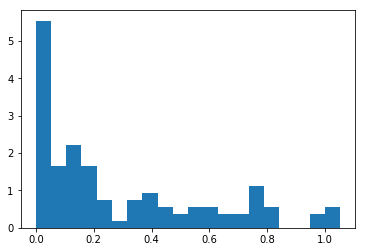

In [145]:
plt.hist(losses_without_nan, normed=True, bins = 20)

Now let's calculate forecastes for all time.

In [149]:
%%time

h = 1
rng = pd.date_range(ts.index[-1]+timedelta(h), ts.index[-1]+timedelta(h))

IES_frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

AES_frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

W_frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

T_frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)



for cntr in ts.columns:


    IES_frc_ts[cntr] = InitExponentialSmoothing(ts[cntr], h, {'alpha':BEST_PARAMS_FOR_MODEL_IES[cntr]['params'][0], 'AdaptationPeriod':40})

    AES_frc_ts[cntr] = AdaptiveExponentialSmoothing(ts[cntr], h, {'alpha':BEST_PARAMS_FOR_MODEL_AES[cntr]['params'][0],
                                                                        'gamma':BEST_PARAMS_FOR_MODEL_AES[cntr]['params'][1],
                                                                        'AdaptationPeriod':40})
    

    W_frc_ts[cntr] = WintersExponentialSmoothing(ts[cntr], h, {'alpha':BEST_PARAMS_FOR_MODEL_WES[cntr]['params'][0],
                                                                     'delta':BEST_PARAMS_FOR_MODEL_WES[cntr]['params'][1],
                                                                     'seasonality_period': 7})


    T_frc_ts[cntr] = Theil_WageExponentialSmoothing(ts[cntr], h, {'alpha':BEST_PARAMS_FOR_MODEL_TWES[cntr]['params'][0], 
                                                                        'beta': BEST_PARAMS_FOR_MODEL_TWES[cntr]['params'][1], 
                                                                        'gamma': BEST_PARAMS_FOR_MODEL_TWES[cntr]['params'][2], 
                                                                        'seasonality_period': 7})



    

CPU times: user 23.3 s, sys: 8 ms, total: 23.3 s
Wall time: 23.8 s


In [ ]:
ALGORITHMS[the_best_alg][cntr]

In [153]:
%%time

ALGORITHMS = {'IES': IES_frc_ts,
              'AES': AES_frc_ts,
              'WES': W_frc_ts, 
              'TWES': T_frc_ts}

FORECAST = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

for cntr in ts.columns:
    if the_best_alg[cntr] != '':

        FORECAST[cntr] = ALGORITHMS[the_best_alg[cntr]][cntr]
        


CPU times: user 128 ms, sys: 4 ms, total: 132 ms
Wall time: 132 ms


Now let's measure loss of FORECAST on time 2006.04.30 - 2006.06.13

In [166]:
ts_loss = ts.loc['2006.04.30':'2006.06.13']
FORECAST_loss = FORECAST.loc['2006.04.30':'2006.06.13']


FORECAST_loss = FORECAST_loss.dropna(axis = 1)
ts_loss = ts_loss[FORECAST_loss.columns]
ts_loss = ts_loss.dropna(axis = 1)
FORECAST_loss = FORECAST_loss[ts_loss.columns]

In [170]:
losses_1 = []
for cntr in ts_loss.columns:
    losses_1.append(qualityMACAPE(ts_loss[cntr], FORECAST_loss[cntr])[0])
    print 'For '+ cntr+' loss is:   '+ str(qualityMACAPE(ts_loss[cntr], FORECAST_loss[cntr])[0])

For item 40010 loss is:   0.977328068295
For item 75501 loss is:   0.133303209195
For item 95519 loss is:   0.881481481481
For item 93400 loss is:   2.3048900686
For item 57813 loss is:   -0.133685875807
For item 34535 loss is:   0.13287578099
For item 33252 loss is:   -0.406677107881
For item 71171 loss is:   -0.143610570914
For item 18065 loss is:   -0.49005843913
For item 40692 loss is:   0.865952433343
For item 16447 loss is:   1.0919245901
For item 41126 loss is:   1.14561101998
For item 32218 loss is:   -0.0574004707028
For item 82195 loss is:   1.16862010592
For item 21329 loss is:   0.133190471552
For item 41520 loss is:   0.132532583383
For item 89407 loss is:   -0.10028222567
For item 86025 loss is:   1.12152049516
For item 51600 loss is:   0.132395560719
For item 94986 loss is:   -0.235046600006
For item 70328 loss is:   1.09859556626
For item 91168 loss is:   0.0443889060959
For item 88273 loss is:   -0.331924290737
For item 25170 loss is:   0.46622481797
For item 28755 los

(array([ 0.06825083,  0.06825083,  0.40950496,  1.09201322,  1.09201322,
         0.40950496,  0.47775578,  0.40950496,  0.20475248,  0.34125413,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.06825083,  0.        ,  0.        ,  0.        ,  0.06825083]),
 array([-0.89025224, -0.67790677, -0.4655613 , -0.25321583, -0.04087036,
         0.1714751 ,  0.38382057,  0.59616604,  0.80851151,  1.02085698,
         1.23320244,  1.44554791,  1.65789338,  1.87023885,  2.08258432,
         2.29492979,  2.50727525,  2.71962072,  2.93196619,  3.14431166,
         3.35665713]),
 <a list of 20 Patch objects>)

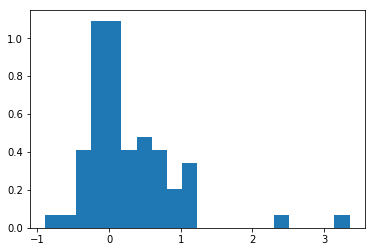

In [173]:
plt.hist(losses_1, normed=True, bins = 20)

The histograms of losses_without_nan and losses_1 are not the same, we see that in losses_1 there are some items, for which losses are big (by absolute value).